# <p style="text-align: center;">Project 2 - Do you need more signs?</p>
### <p style="text-align: center;">Davi N.</p>

### **1. Import the Required Libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image 
import os
from skimage.io import  imread, imshow 
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.utils.spectral_norm as spectral_norm
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
import torch.autograd as autograd
import re
from torchvision import datasets, transforms
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.transforms.functional import resize
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.utils as vutils
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn import preprocessing
from scipy.stats import entropy
from scipy.signal import savgol_filter
from scipy.linalg import sqrtm
import random
from tqdm.auto import tqdm
from six.moves import xrange
import einops
import imageio
from einops import rearrange

c:\Users\davic\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu") # Check a better way to train the model instead of the CPU
# Setting reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
print(device)

cuda


###### **CUDA MEMORY**

In [3]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

In [4]:
#flag_clean_memory = False
flag_clean_memory = True
if flag_clean_memory == True:
    torch.cuda.empty_cache()

### **2. Load the Image Training and Test Datasets**

#### i. Get the Image Dataset Paths

In [5]:
train_dataset_path = 'data-students/TRAIN/'
test_dataset_path = 'data-students/TEST'

#### ii. Load Image Datasets 

We are going for the tiny version of the dataset!

In [6]:
IMG_WIDTH = 75
IMG_HEIGHT = 75
BATCH_SIZE = 32
N_CLASS = 10

Loading the training dataset. Via DataGenerators

In [7]:
transform = transforms.Compose([transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),transforms.ToTensor()])
traffic_signals_dataset = datasets.ImageFolder(root=train_dataset_path, transform=transform)

Split the Training Folder in Training / Validation

In [8]:
train_idx, valid_idx = train_test_split(
    range(len(traffic_signals_dataset)),
    test_size=0.1,
    shuffle=True,
    stratify=traffic_signals_dataset.targets
)

train_subset = Subset(traffic_signals_dataset, train_idx)
valid_subset = Subset(traffic_signals_dataset, valid_idx)

train_dataset_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
validation_dataset_loader = DataLoader(valid_subset, batch_size=64, shuffle=False)

Loading the test dataset.

In [9]:
class TestDataset(Dataset):
    def get_int(self, text):
        return [int(c) if c.isdigit() else c for c in re.split('(\d+)', text)]
    
    def __init__(self, images_folder, transform=None):
        self.images_folder = images_folder
        self.image_files = [f for f in os.listdir(images_folder) if os.path.isfile(os.path.join(images_folder, f))]
        self.image_files.sort(key=self.get_int)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

inference_dataset = TestDataset(images_folder=test_dataset_path, transform=transform)

test_dataset_loader = DataLoader(inference_dataset, batch_size=BATCH_SIZE, shuffle=False)

#### **iii. Get the Label Mappings**

The labels dictionary is made in order to retrive the class names against the label indices used for training the model

In [10]:
### subset version
labels = {value: key for key, value in traffic_signals_dataset.class_to_idx.items()}
print(labels)
the_real_labels = {}
with open("data-students/labels.csv","r") as label_f:
    for line in label_f.readlines()[1:]:
        label_value, label_description = line.strip().split(";")
        the_real_labels[int(label_value)] = label_description 

print(the_real_labels)

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value} - {the_real_labels[int(value)]}")
the_labels_map = {key: value for key, value in traffic_signals_dataset.class_to_idx.items()}
print(len(labels))

{0: '12', 1: '13', 2: '24', 3: '38', 4: '39', 5: '44', 6: '46', 7: '49', 8: '50', 9: '6'}
{6: 'Speed limit (70km/h)', 12: 'Dont Go Left or Right', 13: 'Dont Go Right', 22: 'Cenas', 24: 'Go Right', 37: 'Children crossing', 38: 'Dangerous curve to the right', 39: 'Dangerous curve to the left', 44: 'Go left or straight', 46: 'Unknown', 49: 'Unk1', 50: 'Fences', 54: 'Do Not Park', 55: 'Do', 57: 'Forbidden'}
Label Mappings for classes present in the training and validation datasets

0 : 12 - Dont Go Left or Right
1 : 13 - Dont Go Right
2 : 24 - Go Right
3 : 38 - Dangerous curve to the right
4 : 39 - Dangerous curve to the left
5 : 44 - Go left or straight
6 : 46 - Unknown
7 : 49 - Unk1
8 : 50 - Fences
9 : 6 - Speed limit (70km/h)
10


### **3. Plotting Sample Training Images**

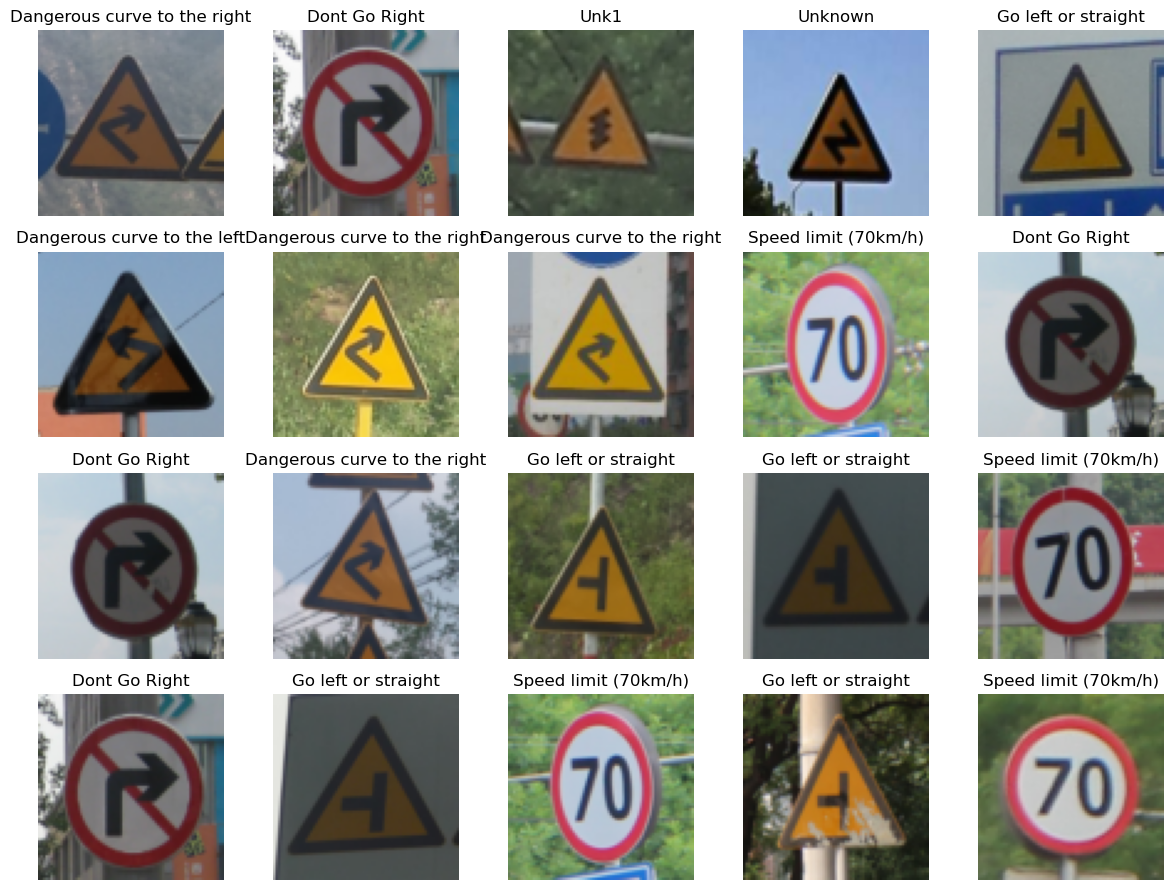

In [11]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(12, 9))
dataiter = iter(traffic_signals_dataset)
idx = 0

all_images_labels = list(traffic_signals_dataset)

for i in range(4):
    for j in range(5):
        img, l = random.choice(all_images_labels) # Randomly selecting an image and label
        label = the_real_labels[int(labels[l])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(img.permute(1,2,0))
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.show()

In [12]:
def max_min_values(dataset, type=0):
    max_value = float('-inf')
    min_value = float('inf')

    for batch in dataset:
        images, _ = batch
        max_batch = images.max()
        min_batch = images.min()
        if max_batch > max_value:
            max_value = max_batch
        if min_batch < min_value:
            min_value = min_batch
        
    print("Maximum pixel value:", max_value)
    print("Minimum pixel value:", min_value)

In [13]:
# normalize the data 
max_min_values(train_dataset_loader) # train
max_min_values(validation_dataset_loader) # validation

print(img.shape)

Maximum pixel value: tensor(1.)
Minimum pixel value: tensor(0.)
Maximum pixel value: tensor(0.9804)
Minimum pixel value: tensor(0.)
torch.Size([3, 75, 75])


In [14]:
def plot_distribution(dataset):
    labels = {0:'12',1:'13',2:'24',3:'37',4:'38',5:'39',6:'44',7:'50',8:'6'}

    t_targets = {label: 0 for label in dataset.dataset.class_to_idx.values()}
    for input, label in dataset:
        t_targets[label] += 1
    
    print('Training class distribution:', t_targets)
    
    # visualize the  class distribution
    plt.figure(figsize=(5, 5))
    sns.barplot(data = pd.DataFrame.from_dict([t_targets]).melt(), 
                x = "variable", y="value", hue="variable").set_title('Class Distribution of the dataset')

Training class distribution: {0: 11, 1: 9, 2: 7, 3: 27, 4: 31, 5: 27, 6: 8, 7: 9, 8: 50, 9: 70}


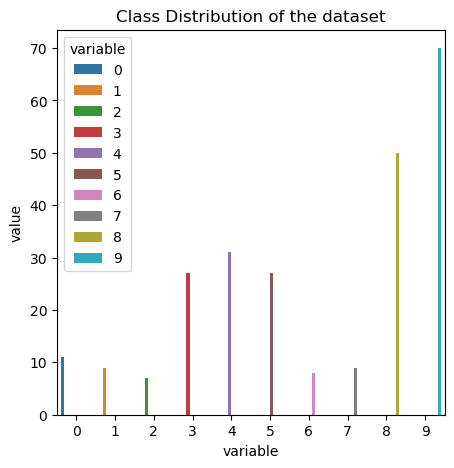

In [15]:
plot_distribution(train_subset)

Training class distribution: {0: 1, 1: 1, 2: 1, 3: 3, 4: 3, 5: 3, 6: 1, 7: 1, 8: 6, 9: 8}


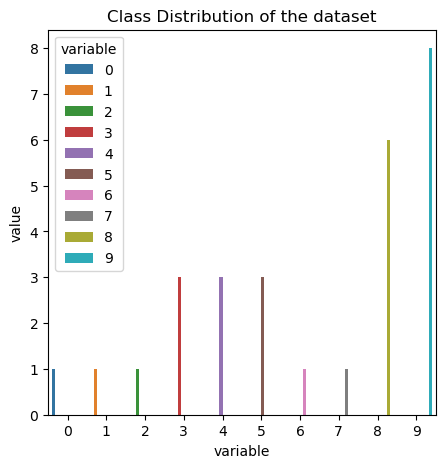

In [16]:
plot_distribution(valid_subset)

In [17]:
# Since the data in not balanced the behavior of the models should be different for each label.
# For this problem, weighted loss was implemented
labels_ = traffic_signals_dataset.targets
class_weights = compute_class_weight('balanced', classes=np.unique(labels_), y=labels_)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

### **4. Data Generation**

##### **Auxiliary Functions**

In [18]:
def clear_cuda_memory():
    torch.cuda.empty_cache()
    for obj in list(globals().values()):
        if torch.is_tensor(obj) and obj.is_cuda:
            del obj
    torch.cuda.empty_cache()

In [19]:
def plot_losses(losses, type=0):
    class_names = ["Dont Go Left or Right", "Dont Go Right", "Go Right", "Dangerous curve to the right", 
                    "Dangerous curve to the left", "Go left or straight", "Unknown", "Unk1", "Fences", "Speed limit (70km/h)"]
        
    if type == 0: # GANs
        fig, axs = plt.subplots(2, 5, figsize=(25, 10))
        axs = axs.flatten()
        
        fig.suptitle('Generator Losses')
        for i in range(N_CLASS):
            axs[i].plot(losses[0][str(i)])
            axs[i].set_title(class_names[i])
        plt.tight_layout()
        plt.show()
        
        fig, axs = plt.subplots(2, 5, figsize=(25, 10))
        axs = axs.flatten()
        
        fig.suptitle('Discriminator Losses')
        for i in range(N_CLASS):
            axs[i].plot(losses[1][str(i)], color='orange')
            axs[i].set_title(class_names[i])
        plt.tight_layout()
        plt.show()
    elif type == 1: # Diffusion Model
        fig, axs = plt.subplots(2, 5, figsize=(25, 10))
        axs = axs.flatten()
        
        fig.suptitle('Model Training Losses')
        for i in range(N_CLASS):
            axs[i].plot(losses[str(i)])
            axs[i].set_title(class_names[i])
        plt.tight_layout()
        plt.show()
    else: # VQ-VAE    
        train_res_recon_error_smooth = savgol_filter(losses[1], 201, 7)
        train_res_perplexity_smooth = savgol_filter(losses[2], 201, 7)
        
        plt.title('Model Training Losses')
        plt.plot(losses[0])
        plt.show()
        
        f = plt.figure(figsize=(8,8))
        ax = f.add_subplot(1,2,1)
        ax.plot(train_res_recon_error_smooth)
        ax.set_yscale('log')
        ax.set_title('Smoothed NMSE.')
        ax.set_xlabel('iteration')

        ax = f.add_subplot(1,2,2)
        ax.plot(train_res_perplexity_smooth)
        ax.set_title('Smoothed Average codebook usage (perplexity).')
        ax.set_xlabel('iteration')

In [20]:
def calculate_fid(real_images_loader, generated_images):
    model = inception_v3(pretrained=True, transform_input=False).cuda()
    model.fc = torch.nn.Identity()  # Remove final fully connected layer
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    def preprocess_image(tensor_image):
        image = tensor_image.permute(1, 2, 0).cpu().numpy() 
        image = (image * 255).astype(np.uint8)  
        pil_image = Image.fromarray(image)
        return transform(pil_image).unsqueeze(0) 
    
    def get_activations(dataloader, is_generated=False):
        activations = []
        for batch in dataloader:
            if is_generated:
                images = batch[0].cuda()
            else:
                images = batch[0]  
                images = torch.cat([preprocess_image(image) for image in images], dim=0).cuda()
            with torch.no_grad():
                act = model(images).cpu().numpy()
            activations.append(act)
        return np.concatenate(activations, axis=0)

    real_activations = get_activations(real_images_loader)
    
    # Create a DataLoader for generated images
    generated_images_dataset = TensorDataset(generated_images)
    generated_images_loader = DataLoader(generated_images_dataset, batch_size=32, shuffle=False)
    
    generated_activations = get_activations(generated_images_loader, is_generated=True)

    mu1, sigma1 = real_activations.mean(axis=0), np.cov(real_activations, rowvar=False)
    mu2, sigma2 = generated_activations.mean(axis=0), np.cov(generated_activations, rowvar=False)

    diff = mu1 - mu2
    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

In [21]:
def inception_score(images, batch_size=32, splits=10):
    # Load pre-trained Inception v3 model
    inception_model = inception_v3(pretrained=True, transform_input=False).eval().cuda()

    # Prepare the images
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    def preprocess_image(tensor_image):
        # Convert tensor to PIL Image
        image = tensor_image.permute(1, 2, 0).cpu().detach().numpy()  
        image = (image * 255).astype(np.uint8) 
        pil_image = Image.fromarray(image)
        return transform(pil_image).unsqueeze(0)  

    transformed_images = [preprocess_image(image) for image in images]
    images_tensor = torch.cat(transformed_images, dim=0)
    dataloader = DataLoader(images_tensor, batch_size=batch_size, shuffle=False, num_workers=0)

    preds = []
    for batch in dataloader:
        batch = batch.cuda()
        with torch.no_grad():
            pred = torch.nn.functional.softmax(inception_model(batch), dim=1)
        preds.append(pred.cpu().numpy())

    preds = np.concatenate(preds, axis=0)

    split_scores = []
    for k in range(splits):
        part = preds[k * (preds.shape[0] // splits): (k + 1) * (preds.shape[0] // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

In [22]:
def calculate_ssim(real_images_loader, generated_images, win_size=3, data_range=1.0):
    ssims = []

    generated_images = generated_images.permute(0, 2, 3, 1).cpu().detach().numpy()

    for real_batch, gen_img in zip(real_images_loader, generated_images):
        real_batch = real_batch[0] 
        for real_img in real_batch:
            real_img = real_img.permute(1, 2, 0).cpu().numpy()  
            gen_img = gen_img  
            
            s = ssim(real_img, gen_img, win_size=win_size, multichannel=True, data_range=data_range)
            ssims.append(s)
    
    return np.mean(ssims)

In [23]:
def evaluate_models(model, dataloader, device, type=1 ,num_images=20):
    fid_scores = []
    ssim_scores = []
    inception_scores = []

    for class_index in range(N_CLASS):
        # Generate fake images
        if(type == 1): # cGAN
            model[str(class_index)].eval()
        else: # DiT
            model[class_index].eval()
        fake_images = []
        with torch.no_grad():
            for _ in range(num_images):
                if(type == 1): # cGAN
                    noise = torch.randn(1, 128, 1, 1, device=device)
                    label = torch.tensor([class_index], dtype=torch.long, device=device)
                    fake_image = model[str(class_index)](noise, label)
                else:
                    fake_image = model[class_index].sample(device)
                    
                fake_images.append(fake_image.squeeze(0))
                
        fake_images = torch.stack(fake_images)
        
        # Collect real images
        real_images = []
        for images, labels in dataloader:
            class_mask = labels == class_index
            real_images.append(images[class_mask])
            if len(real_images) * dataloader.batch_size >= num_images:
                break
        real_images = torch.cat(real_images)[:num_images].to(device)

        # Calculate metrics
        fid_score = calculate_fid(DataLoader(TensorDataset(real_images)), fake_images)
        ssim_score = calculate_ssim(DataLoader(TensorDataset(real_images)), fake_images)
        inception_score_mean, inception_score_std = inception_score(fake_images)

        fid_scores.append(fid_score)
        ssim_scores.append(ssim_score)
        inception_scores.append((inception_score_mean, inception_score_std))

    mean_fid = np.mean(fid_scores)
    mean_ssim = np.mean(ssim_scores)
    mean_is = np.mean([score[0] for score in inception_scores])
    std_is = np.mean([score[1] for score in inception_scores])

    print(f"Mean FID: {mean_fid}, Mean SSIM: {mean_ssim}, Mean IS: {mean_is}, STD IS: {std_is}")

#### **VQ-VAE**

In [ ]:
# SOURCE: https://colab.research.google.com/github/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb#scrollTo=STZK1kZyv1j8

###### **Auxiliary Functions**

In [22]:
def calculate_variance(data_loader): # Calculates the vaiance of the dataset
    pixel_sum = 0
    pixel_sum_squared = 0
    num_pixels = 0

    for images, _ in data_loader:
        images = images.view(images.size(0), -1) 
        pixel_sum += images.sum(dim=0)
        pixel_sum_squared += (images ** 2).sum(dim=0)
        num_pixels += images.size(0) * images.size(1) 

    mean = pixel_sum / num_pixels
    mean_squared = pixel_sum_squared / num_pixels
    variance = mean_squared - mean ** 2

    return variance.mean().item()

In [23]:
def show_images(images, title=None): # shows the images
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    for i, img in enumerate(images):
        img = img.permute(1, 2, 0).cpu().numpy()
        
        # Normalize to [0, 1] 
        if img.max() > 1:
            img = img / 255.0
        
        # Clip to valid range [0, 1]
        img = np.clip(img, 0, 1)
        
        axs[i].imshow(img)
        axs[i].axis('off')
    if title:
        plt.suptitle(title)
    plt.show()

In [24]:
def generate_images_with_labels(model, num_labels, device='cpu'): # generates images of each label
    model.eval()
    generated_images = []
    for label in range(num_labels):
        random_noise = torch.randn(1, 3, 32, 32).to(device)
        label_tensor = torch.tensor([label]).to(device)
        with torch.no_grad():
            _, generated_image, _ = model(random_noise, label_tensor)
        generated_images.append(generated_image.squeeze(0))
    return generated_images

In [25]:
def generate_images(model, dataloader, num_images=10):
    generated_images = []
    labels = []
    for i, (x, label) in enumerate(dataloader):
        if i >= num_images:
            break
        
        x = x.cuda()
        label = label.cuda()
        
        # Encode the images
        z = model._encoder(x)
        z = model._pre_vq_conv(z)
        loss, quantized, perplexity, _ = model._vq_vae(z)
        
        # Concatenate the label with the quantized output
        label_one_hot = F.one_hot(label, num_classes=model.num_classes).float()
        label_one_hot = label_one_hot.unsqueeze(2).unsqueeze(3)
        label_one_hot = label_one_hot.expand(-1, -1, quantized.size(2), quantized.size(3))
        quantized = torch.cat([quantized, label_one_hot], dim=1)
        
        # Decode the quantized latent codes to generate images
        generated = model._decoder(quantized)
        generated = model.upsample(generated)
        generated_images.append(generated)
        labels.append(label)
    
    # Concatenate all generated images
    generated_images = torch.cat(generated_images, dim=0)
    return generated_images, torch.cat(labels, dim=0)

###### **Architecture**

In [26]:
class VectorQuantizer(nn.Module): 
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        flat_input = inputs.view(-1, self._embedding_dim) # Flattens the input
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and un-flattens
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Calculate the Loss for the encoding and the quantize 
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [27]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and un-flattens
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Calculate the Loss for the encoding
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [28]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                    out_channels=num_residual_hiddens,
                    kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                    out_channels=num_hiddens,
                    kernel_size=1, stride=1, bias=False)
        )
    
    def forward(self, x):
        return x + self._block(x)

In [29]:
class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                            for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [30]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels, num_hiddens//2, 4, 2, 1)
        self._conv_2 = nn.Conv2d(num_hiddens//2, num_hiddens, 4, 2, 1)
        self._conv_3 = nn.Conv2d(num_hiddens, num_hiddens, 3, 1, 1)
        self._conv_4 = nn.Conv2d(num_hiddens, num_hiddens, 3, 1, 1)
        self._residual_stack = ResidualStack(num_hiddens, num_hiddens, num_residual_layers, num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)
        
        x = self._conv_2(x)
        x = F.relu(x)
        
        x = self._conv_3(x)
        x = F.relu(x)
        
        x = self._conv_4(x)
        return self._residual_stack(x)

In [31]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()
        
        self._conv_1 = nn.Conv2d(in_channels, num_hiddens, 3, 1, 1)
        self._residual_stack = ResidualStack(num_hiddens, num_hiddens, num_residual_layers, num_residual_hiddens)
        self._conv_trans_1 = nn.ConvTranspose2d(num_hiddens, num_hiddens//2, 4, 2, 1)
        self._conv_trans_2 = nn.ConvTranspose2d(num_hiddens//2, num_hiddens//4, 4, 2, 1)
        self._conv_trans_3 = nn.ConvTranspose2d(num_hiddens//4, 3, 4, 2, 1)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = self._residual_stack(x)
        
        x = self._conv_trans_1(x)
        x = F.relu(x)
        
        x = self._conv_trans_2(x)
        x = F.relu(x)
        
        return self._conv_trans_3(x)

In [32]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, 
                num_embeddings, embedding_dim, commitment_cost, num_classes, decay=0):
        super(Model, self).__init__()
        
        self.num_classes = num_classes
        self._encoder = Encoder(3, num_hiddens, num_residual_layers, num_residual_hiddens)
        
        self._pre_vq_conv = nn.Conv2d(num_hiddens, embedding_dim, 1, 1)
        if decay > 0.0: # checks if the decay is positive
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
            
        self._decoder = Decoder(embedding_dim + num_classes, num_hiddens, num_residual_layers, num_residual_hiddens)
        self.upsample = nn.Upsample(size=(75, 75), mode='bilinear', align_corners=True) # Upsample the image to the original size

    def forward(self, x, label):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        
        # Concatenate the label with the quantized output
        label_one_hot = F.one_hot(label, num_classes=self.num_classes).float()
        label_one_hot = label_one_hot.unsqueeze(2).unsqueeze(3) 
        label_one_hot = label_one_hot.expand(-1, -1, quantized.size(2), quantized.size(3))  
        quantized = torch.cat([quantized, label_one_hot], dim=1)
        
        x_recon = self._decoder(quantized)
        x_recon = self.upsample(x_recon)  # Upsample to original size

        return loss, x_recon, perplexity

###### **Train**

In [33]:
def train(training_loader, data_variance, device):
    batch_size = 256
    num_training_updates = 15000

    num_hiddens = 128
    num_residual_hiddens = 32
    num_residual_layers = 3

    embedding_dim = 256
    num_embeddings = 2048
    
    commitment_cost = 0.25

    decay = 0.99

    learning_rate = 1e-4

    model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
            num_embeddings, embedding_dim, commitment_cost, num_classes=10, decay=0).to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5) # Initialize the learning rate scheduler
    
    model.train()
    train_res_recon_error = []
    train_res_perplexity = []
    losses = []

    for i in xrange(num_training_updates):
        (data, label) = next(iter(training_loader))
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()

        vq_loss, data_recon, perplexity = model(data, label)
        recon_error = F.mse_loss(data_recon, data) / data_variance
        loss = recon_error + vq_loss
        loss.backward()

        optimizer.step()
        scheduler.step() 
        
        train_res_recon_error.append(recon_error.item())
        train_res_perplexity.append(perplexity.item())
        losses.append(loss.item())

        if (i+1) % 1000 == 0 or i == 0:
            print('[%d/%d]' % (i+1,num_training_updates))
            print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
            print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
            
            if (i == num_training_updates):
                gen_imgs = generate_images_with_labels(model, 10, device)
                show_images(gen_imgs)
            
    return model, [losses, train_res_recon_error, train_res_perplexity]

In [34]:
data_variance = calculate_variance(train_dataset_loader)
model, losses = train(train_dataset_loader, data_variance, device)

[1/15000]
recon_error: 17093.135
perplexity: 2.170
[1000/15000]
recon_error: 3012.702
perplexity: 1.000
[2000/15000]
recon_error: 2600.230
perplexity: 1.119
[3000/15000]
recon_error: 2190.134
perplexity: 1.793
[4000/15000]
recon_error: 2126.937
perplexity: 1.849
[5000/15000]
recon_error: 2009.448
perplexity: 2.151
[6000/15000]
recon_error: 2120.095
perplexity: 2.352
[7000/15000]
recon_error: 2102.488
perplexity: 2.169
[8000/15000]
recon_error: 2137.071
perplexity: 2.102
[9000/15000]
recon_error: 2130.760
perplexity: 2.039
[10000/15000]
recon_error: 2141.206
perplexity: 2.025
[11000/15000]
recon_error: 2155.674
perplexity: 2.012
[12000/15000]
recon_error: 2135.288
perplexity: 2.009
[13000/15000]
recon_error: 2131.428
perplexity: 2.010
[14000/15000]
recon_error: 2141.618
perplexity: 2.018
[15000/15000]
recon_error: 2145.864
perplexity: 2.011


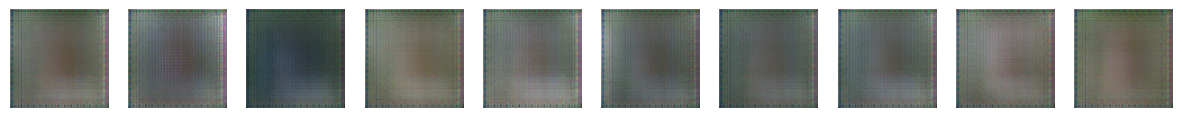

In [35]:
gen_imgs = generate_images_with_labels(model, 10, device)
show_images(gen_imgs)

###### **Evaluation**

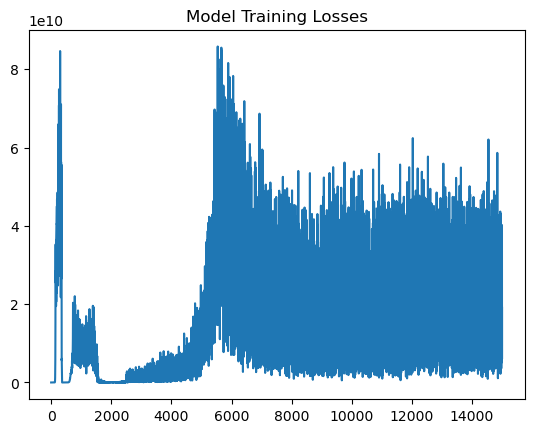

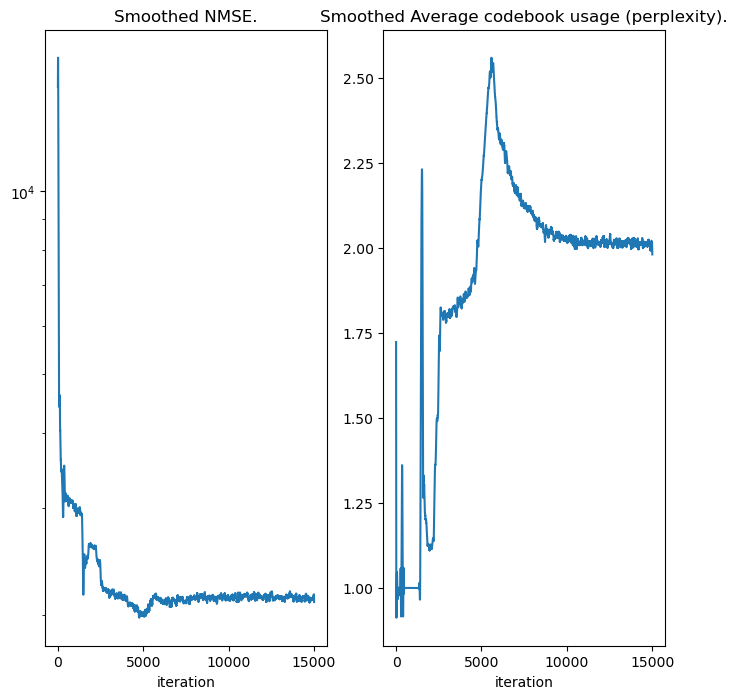

In [36]:
plot_losses(losses, 2)

In [42]:
# SAVE THE MODEL
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)

# Save the state dictionary of the model
model_path = os.path.join(model_dir, 'vqvae_model.pth')
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to models\vqvae_model.pth


In [ ]:
# LOAD THE MODEL
model = Model(num_hiddens=128, num_residual_layers=3, num_residual_hiddens=32,
            num_embeddings=2048, embedding_dim=256, commitment_cost=0.25, 
            num_classes=10, decay=0.99).to(device)

# Load the state dictionary into the model
model_path = os.path.join('models', 'vqvae_model.pth')
model.load_state_dict(torch.load(model_path, map_location=device))

print(f"Model loaded from {model_path}")

In [38]:
generated_images, labels = generate_images(model, train_dataset_loader, num_images=10)

In [39]:
mean_is, std_is = inception_score(generated_images)
print(f'Inception Score: {mean_is} ± {std_is}')

c:\Users\davic\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\davic\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception Score: 1.6097080707550049 ± 0.1488834172487259


In [40]:
fid = calculate_fid(train_dataset_loader, generated_images)
print(f'FID: {fid}')

FID: 381.0594118360659


In [41]:
# Calculate SSIM
mean_ssim = calculate_ssim(train_dataset_loader, generated_images, win_size=3, data_range=1.0)
print(f'SSIM: {mean_ssim}')

SSIM: 0.20756415795633223


In [34]:
vq_vae_executionTime = 59.403 # in minutes

#### **Conditional GAN**

###### **Auxiliary Function**

In [24]:
def generate_imgs(models):
    class_names = ["Dont Go Left or Right", "Dont Go Right", "Go Right", "Dangerous curve to the right", 
                "Dangerous curve to the left", "Go left or straight", "Unknown", "Unk1", "Fences", "Speed limit (70km/h)"]
    fig, axs = plt.subplots(1, N_CLASS, figsize=(75, 75))
    z = torch.randn(1, 128, 1, 1, device=device)
    for c in range(N_CLASS):
        gen_labels_g = torch.full((1,), c, dtype=torch.long, device=device)
        with torch.no_grad():
            img_out = models[str(c)](z, gen_labels_g)

        axs[c].imshow((img_out[0].permute(1, 2, 0).cpu().numpy() + 1) / 2)
        axs[c].axis('off')
        axs[c].set_title(class_names[c])
    plt.show()

###### **Architecture**

In [25]:
class ConditionalBatchNorm2d(nn.Module): # enables the linguistic embedding
    def __init__(self, num_features, num_classes=N_CLASS):
        super(ConditionalBatchNorm2d, self).__init__()
        self.num_features = num_features
        self.bn = nn.BatchNorm2d(num_features, affine=False)
        self.embed = nn.Embedding(num_classes, num_features * 2)
        self.embed.weight.data[:, :num_features].normal_(1, 0.02)  
        self.embed.weight.data[:, num_features:].zero_()  

    def forward(self, x, labels):
        gamma, beta = self.embed(labels).chunk(2, 1)
        gamma = gamma.view(-1, self.num_features, 1, 1)
        beta = beta.view(-1, self.num_features, 1, 1)
        return self.bn(x) * gamma + beta

In [26]:
class Generator(nn.Module):
    def __init__(self, latent_dim, channel_size=3):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(N_CLASS, latent_dim)

        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim*2, 1024, 3, 1, 0, bias=False),
            ConditionalBatchNorm2d(1024),
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, 3, 1, 0, bias=False),
            ConditionalBatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 3, 1, 1, bias=False),
            ConditionalBatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            ConditionalBatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            ConditionalBatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            ConditionalBatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, channel_size, 3, 2, 3, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_emb_expanded = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        input = torch.cat((label_emb_expanded, noise), dim=1)  # Concatenate label embeddings and noise
        out = input
        for module in self.model:
            if isinstance(module, ConditionalBatchNorm2d):
                out = module(out, labels)
            else:
                out = module(out)
        return out

In [27]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(N_CLASS, IMG_WIDTH*IMG_HEIGHT)

        self.model = nn.Sequential(
            spectral_norm(nn.Conv2d(4, 64, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(256, 512, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(512, 1, 4, 1, 0, bias=False)),
            nn.Sigmoid() # The output will be a probability
        )

    def forward(self, img, labels):
        label_embedding = self.label_embedding(labels).view(labels.size(0), 1, IMG_WIDTH, IMG_HEIGHT)
        input = torch.cat((img, label_embedding), 1)
        return self.model(input).view(-1, 1).squeeze(1)


###### **Train**

Training progress:   0%|          | 0/1000 [00:00<?, ?it/s]

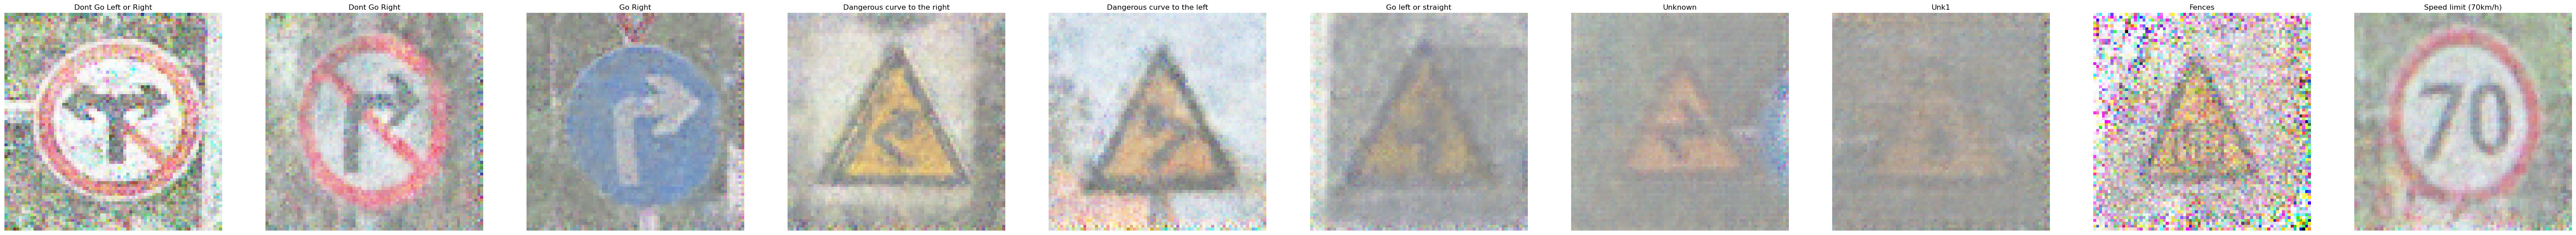

Training complete.


In [50]:
def train_gans(train_loader, class_weights, num_classes=N_CLASS, num_epochs=[10]*10, device='cpu'):
    latent_dim = 128 # Dimension of the latent space
    
    # Dictionaries with all the generators and the discriminators of each labels
    netGs = nn.ModuleDict({str(i): Generator(latent_dim).to(device) for i in range(N_CLASS)})
    netDs = nn.ModuleDict({str(i): Discriminator().to(device) for i in range(N_CLASS)})
    
    # Dictionaries of optimizers 
    optimizersG = {str(i): optim.Adam(netGs[str(i)].parameters(), lr=0.0002, 
                                    betas=(0.5, 0.999)) for i in range(N_CLASS)}
    optimizersD = {str(i): optim.Adam(netDs[str(i)].parameters(), lr=0.0001,
                                    betas=(0.5, 0.999)) for i in range(N_CLASS)}
    
    criterion = nn.BCELoss() # Adversarial loss
    
    fixed_noises = {str(i): torch.randn(1, latent_dim, 1, 1, device=device) for i in range(num_classes)}  # Fixed noise for each class
    class_names = ["Dont Go Left or Right", "Dont Go Right", "Go Right", "Dangerous curve to the right", 
                "Dangerous curve to the left", "Go left or straight", "Unknown", "Unk1", "Fences", "Speed limit (70km/h)"]

    # Variables to track the losses
    g_losses = {str(i): [] for i in range(N_CLASS)}
    d_losses = {str(i): [] for i in range(N_CLASS)}

    for epoch in tqdm(range(max(num_epochs)), desc="Training progress"):
        for i, (imgs, labels) in enumerate(train_loader): # train each label in a different GAN
            
            # Save the image and the label are moved to the device
            imgs, labels = imgs.to(device), labels.to(device)
            
            for class_index in range(N_CLASS): # for each label train
                
                if epoch >= num_epochs[class_index]: # If the number of epochs surpasses the number of epochs for the current class it will not continue to train this class
                    continue  
                
                class_mask = labels == class_index # returns the index of the imgs with the label equals to the current class_index
                
                if class_mask.any(): # check if there are any img with the label in the current batch
                    class_imgs = imgs[class_mask] # get the images with the class_index
                    
                    batch_size = class_imgs.size(0)
                    
                    # Adversarial ground truths - using label smoothing
                    fake_labels = torch.full((batch_size,), 0.1, device=device) # one to label "valid"/"real" images
                    real_labels = torch.full((batch_size,), 0.9, device=device) # zero to label fake images
                    all_labels = torch.full((class_imgs.size(0),), class_index, dtype=torch.long, device=device)
                    
                    # Generate fake images
                    z = torch.randn(class_imgs.size(0), 128, 1, 1, device=device) # Randomly generated a sample from the latent space using a normal distribution with size=(imgs_size, latent_dim)
                    fake_imgs = netGs[str(class_index)](z, torch.full((class_imgs.size(0),), class_index, dtype=torch.long, device=device)) # Generate images with `Generator`
                    
                    #-  Train Discriminator -#
                    optimizersD[str(class_index)].zero_grad() # Clears old gradients
                    
                    # Calculate the loss for the real images
                    real_output = netDs[str(class_index)](class_imgs, all_labels)
                    real_loss = criterion(real_output, real_labels)
                    real_loss = torch.mean(real_loss * class_weights[class_index]) # weighted loss - the imbalance in the dataset only affects the real samples
                    
                    # Calculate the loss for the fake images - train the discriminator to predict fake images
                    fake_output = netDs[str(class_index)](fake_imgs.detach(), all_labels)
                    fake_loss = criterion(fake_output, fake_labels)
                    
                    # Total discriminator loss
                    d_loss = (real_loss + fake_loss) / 2
                    
                    # Updates the weights of the Discriminator based on the gradients calculated.
                    d_loss.backward()
                    #for param in netDs[str(class_index)].parameters():
                    #    param.grad.data.clamp_(-1, 1)
                    optimizersD[str(class_index)].step()

                    #-  Train Generator -#
                    optimizersG[str(class_index)].zero_grad()
                    
                    # Calculate the loss for the fake images - see how good the generator can fool the discriminator
                    g_loss = criterion(netDs[str(class_index)](fake_imgs, torch.full((fake_imgs.size(0),), class_index, dtype=torch.long, device=device)), torch.ones(fake_imgs.size(0), device=device))
                    
                    # Updates the weights of the Generator based on the gradients calculated.
                    g_loss.backward()
                    optimizersG[str(class_index)].step()
                    
                    # Save losses
                    g_losses[str(class_index)].append(g_loss.item())
                    d_losses[str(class_index)].append(d_loss.item())
                    
            if i % 100 == 0:
                print(f"Epoch [{epoch+1}/{max(num_epochs)}], Batch [{i+1}/{len(train_loader)}]")
                for c in range(N_CLASS): # for each class prints the generator and the discriminator losses
                    print(f"  Class {c}: Loss D: {d_losses[str(c)][-1]:.4f}, Loss G: {g_losses[str(c)][-1]:.4f}")
                
            # Visual inspection at certain epochs
            if (epoch % 50 == 0 and i == len(train_loader) - 1) or (epoch == max(num_epochs) - 1 and i == len(train_loader) - 1):
            #if epoch == max(num_epochs) - 1 and i == len(train_loader) - 1:
                fig, axs = plt.subplots(1, num_classes, figsize=(75, 75))
                for c in range(num_classes):
                    gen_labels_g = torch.full((1,), c, dtype=torch.long, device=device)
                    with torch.no_grad():
                        img_out = netGs[str(c)](fixed_noises[str(c)], gen_labels_g)

                    axs[c].imshow((img_out[0].permute(1, 2, 0).cpu().numpy() + 1) / 2)
                    axs[c].axis('off')
                    axs[c].set_title(class_names[c])
                plt.show()        
                
    print("Training complete.")
    return [netGs, netDs], [g_losses, d_losses]

num_epochs_per_class = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]  # Number of epochs for each class
models, losses = train_gans(train_dataset_loader, class_weights, num_epochs=num_epochs_per_class, device=device)

###### **Analysis**

In [ ]:
# Save the models
for class_index in range(N_CLASS):
    model_path = os.path.join('models', f'conditional_gan{class_index}.pth')
    torch.save(models[0][f'{class_index}'].state_dict(), model_path)
    print(f"Model for class {class_index} saved to {model_path}")

Model for class 0 saved to models\conditional_gan0.pth
Model for class 1 saved to models\conditional_gan1.pth
Model for class 2 saved to models\conditional_gan2.pth
Model for class 3 saved to models\conditional_gan3.pth
Model for class 4 saved to models\conditional_gan4.pth
Model for class 5 saved to models\conditional_gan5.pth
Model for class 6 saved to models\conditional_gan6.pth
Model for class 7 saved to models\conditional_gan7.pth
Model for class 8 saved to models\conditional_gan8.pth
Model for class 9 saved to models\conditional_gan9.pth


In [28]:
# load the models
models = {}  # Dictionary to hold the loaded models
latent_dim = 128
for class_index in range(N_CLASS):
    model = Generator(latent_dim).to(device)  # Initialize the model architecture
    model_path = os.path.join('models/conditional gans/', f'conditional_gan{class_index}.pth')
    
    # Load the state dictionary into the model
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    # Put the model in evaluation mode
    model.eval()
    
    # Store the model in the dictionary
    models[f'{class_index}'] = model

Model for class 0 loaded from models/conditional gans/conditional_gan0.pth
Model for class 1 loaded from models/conditional gans/conditional_gan1.pth
Model for class 2 loaded from models/conditional gans/conditional_gan2.pth
Model for class 3 loaded from models/conditional gans/conditional_gan3.pth
Model for class 4 loaded from models/conditional gans/conditional_gan4.pth
Model for class 5 loaded from models/conditional gans/conditional_gan5.pth
Model for class 6 loaded from models/conditional gans/conditional_gan6.pth
Model for class 7 loaded from models/conditional gans/conditional_gan7.pth
Model for class 8 loaded from models/conditional gans/conditional_gan8.pth
Model for class 9 loaded from models/conditional gans/conditional_gan9.pth


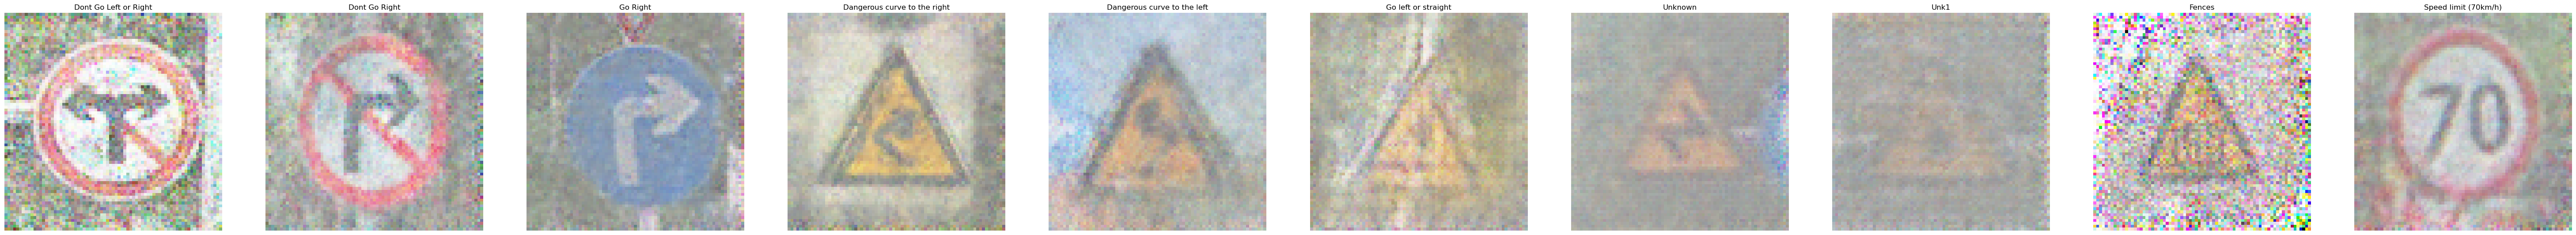

In [75]:
generate_imgs(models)

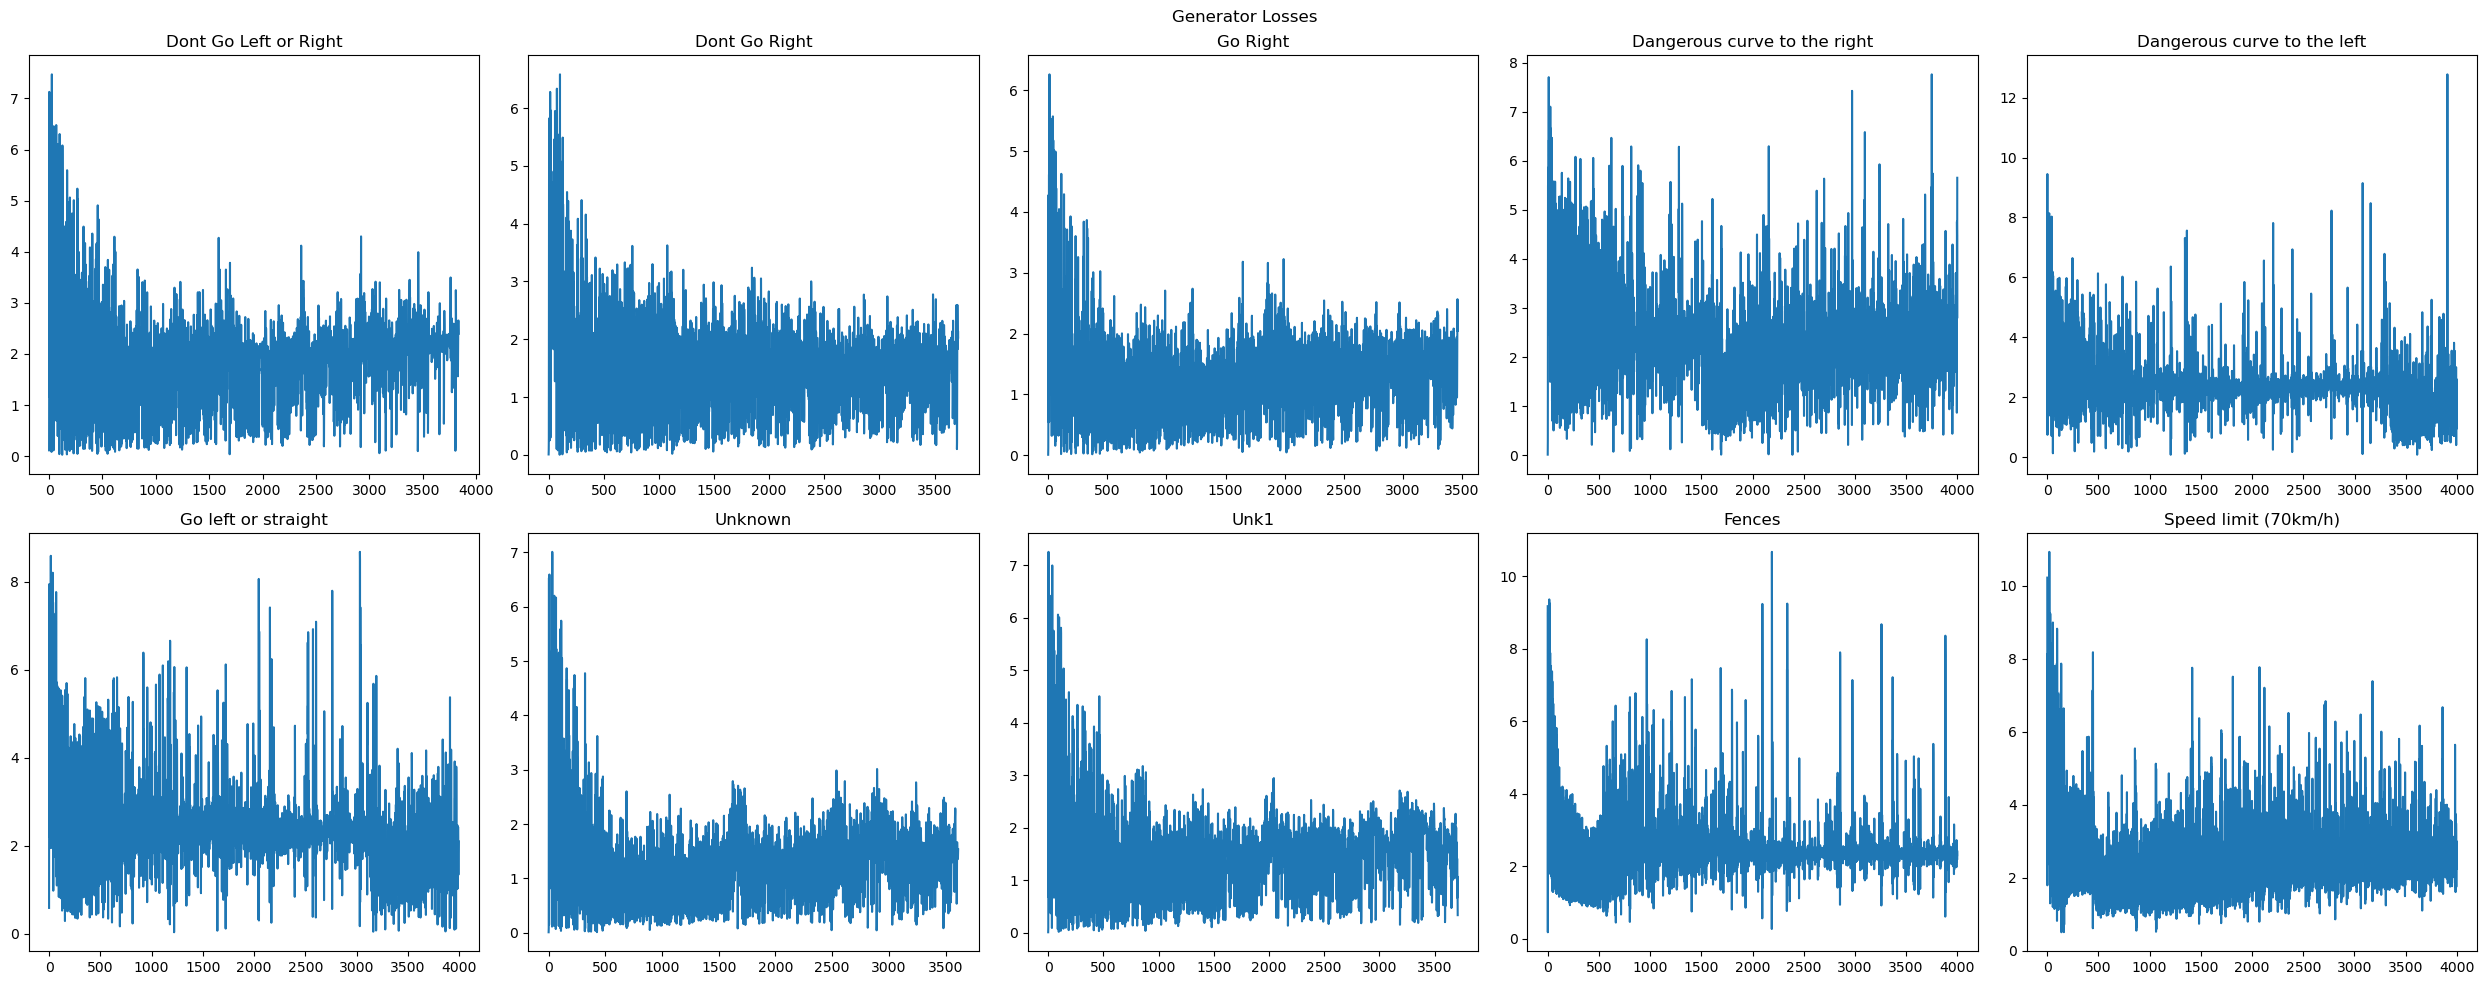

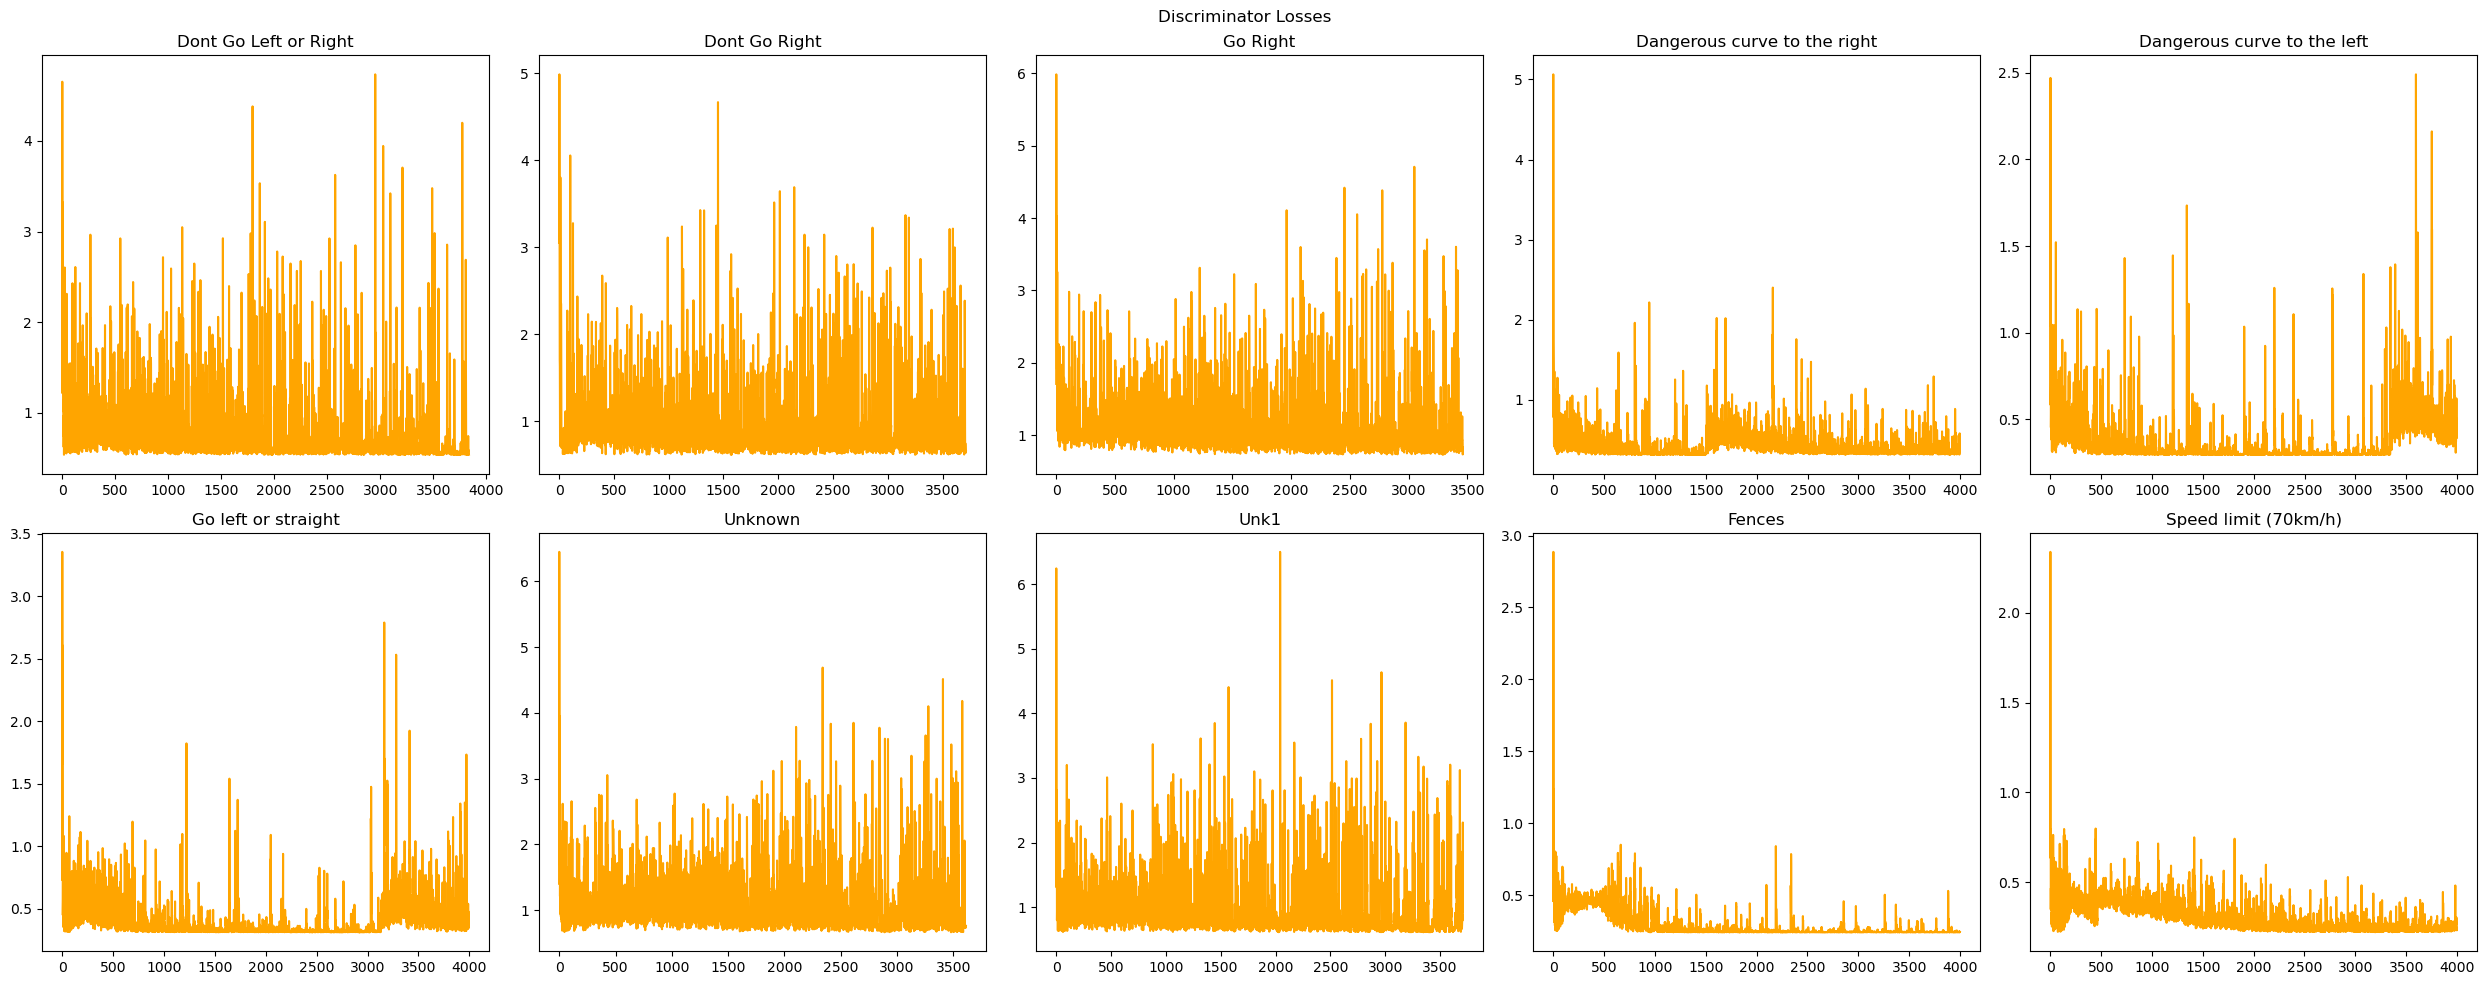

In [72]:
plot_losses(losses)

In [66]:
evaluate_models(models, train_dataset_loader, device, type=1)

c:\Users\davic\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\davic\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Mean FID: 589.074112086958, Mean SSIM: 0.2487293165773094, Mean IS: 1.110503911972046, STD IS: 0.07512623071670532


In [33]:
conditional_gan_executionTime = 125.53 # in minutes

#### **Diffusion Transformer**

In [ ]:
# SOURCEs: https://github.com/NVlabs/DiffiT & https://github.com/facebookresearch/DiT

##### **w/ Class Embedding**

###### **Auxiliary Functions**

In [24]:
def generate_and_display_images(model, num_classes, device):
    sampled_images, class_labels = model.sample(num_classes, device)
    sampled_images = sampled_images.cpu().numpy().transpose(0, 2, 3, 1)  
    class_names = ["Dont Go Left or Right", "Dont Go Right", "Go Right", "Dangerous curve to the right", 
                "Dangerous curve to the left", "Go left or straight", "Unknown", "Unk1", "Fences", "Speed limit (70km/h)"]

    fig, axes = plt.subplots(1, num_classes, figsize=(num_classes * 2, 2))
    for i in range(num_classes):
        axes[i].imshow((sampled_images[i] * 255).astype(np.uint8))
        axes[i].set_title(class_names[i])
        axes[i].axis('off')
    plt.show()

###### **Architecture**

In [25]:
class VisionTransformer(nn.Module):
    def __init__(self, image_size=75, patch_size=5, num_classes=10, dim=512, depth=6, heads=8, mlp_dim=1024, channels=3):
        super(VisionTransformer, self).__init__()
        assert image_size % patch_size == 0, 'Image size must be divisible by patch size'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size * patch_size

        self.patch_size = patch_size
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.class_embedding = nn.Embedding(num_classes, dim)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        
        self.to_cls_token = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, image_size * image_size * channels) 
        )
        self.image_size = image_size
        self.channels = channels

    def forward(self, img, class_labels):
        p = self.patch_size
        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        x = self.patch_to_embedding(x)
        b, n, _ = x.shape

        cls_tokens = self.cls_token.expand(b, -1, -1)
        class_emb = self.class_embedding(class_labels).unsqueeze(1)
        x = torch.cat((cls_tokens + class_emb, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.transformer(x)
        x = self.to_cls_token(x[:, 0])
        x = self.mlp_head(x)

        # Reshape to match the original image dimensions
        x = x.view(b, self.channels, self.image_size, self.image_size)
        return x

In [26]:
class DiffusionModel(nn.Module):
    def __init__(self, vit: VisionTransformer, timesteps=1000):
        super(DiffusionModel, self).__init__()
        self.vit = vit
        self.timesteps = timesteps
        self.betas = torch.linspace(1e-4, 0.02, timesteps)
        self.alphas = 1 - self.betas
        self.alpha_hats = torch.cumprod(self.alphas, dim=0)

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        alpha_hat_t = self.alpha_hats.to(x_start.device)[t].view(-1, 1, 1, 1) 
        return (
            alpha_hat_t ** 0.5 * x_start +
            (1 - alpha_hat_t) ** 0.5 * noise
        )

    def forward(self, x_start, t, class_labels):
        noise = torch.randn_like(x_start)
        x_noisy = self.q_sample(x_start, t, noise)
        return self.vit(x_noisy, class_labels)
    
    def sample(self, num_classes, device):
        self.eval()
        with torch.no_grad():
            x = torch.randn((num_classes, 3, self.vit.image_size, self.vit.image_size)).to(device)
            class_labels = torch.arange(num_classes, device=device) 
            for t in reversed(range(self.timesteps)):
                t_batch = torch.tensor([t] * num_classes, device=device)
                x = self.vit(x, class_labels)
        return x, class_labels

###### **Training**

In [30]:
def train(model, dataloader, optimizer, epochs=10, device=device):
    mse = nn.MSELoss()
    
    model.to(device)
    
    losses = []
        
    for epoch in tqdm(range(epochs), desc="Training progress"):
        model.train()
        epoch_loss = 0.0
        
        for imgs, labels in dataloader:
            optimizer.zero_grad()
            
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            t = torch.randint(0, model.timesteps, (imgs.size(0),), device=device)
            out_img = model(imgs, t, labels) 
            
            loss = mse(out_img, imgs)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            losses.append(loss.item())
        
        avg_loss = epoch_loss / len(dataloader)
        
    return losses

In [ ]:
# Initialize the model, optimizer, and start training
vit = VisionTransformer(image_size=75, patch_size=5, num_classes=10, dim=512, depth=6, heads=8, mlp_dim=1024, channels=3)
diffusion_model = DiffusionModel(vit)
optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=1e-4)

train(diffusion_model, train_dataset_loader, optimizer, epochs=700, device=device)

###### **Evaluation**

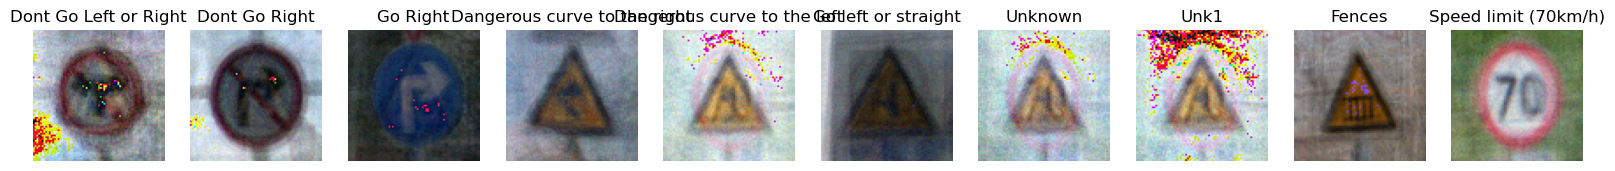

In [23]:
generate_and_display_images(diffusion_model, N_CLASS, device)

##### **w/ Multi models**

###### **Auxiliary Functions**

In [24]:
def sample_images(models, num_classes, device): # sample one image of each class
    sampled_images = []
    class_labels = []
    for i in range(num_classes):
        img = models[i].sample(device)
        sampled_images.append(img)
        class_labels.append(i)
    return torch.cat(sampled_images), torch.tensor(class_labels, device=device)

In [25]:
def sample_image(model, device): # sample one image of an specific model
    model.eval()
    with torch.no_grad():
        img = model.sample(device)
    return img

In [26]:
def generate_and_display_images(models, num_classes, device): # plots the images
    sampled_images, class_labels = sample_images(models, num_classes, device)
    sampled_images = sampled_images.cpu().numpy().transpose(0, 2, 3, 1)  
    class_names = ["Dont Go Left or Right", "Dont Go Right", "Go Right", "Dangerous curve to the right", 
                "Dangerous curve to the left", "Go left or straight", "Unknown", "Unk1", "Fences", "Speed limit (70km/h)"]

    fig, axes = plt.subplots(1, num_classes, figsize=(num_classes * 2, 2))
    for i in range(num_classes):
        axes[i].imshow((sampled_images[i] * 255).astype(np.uint8))
        axes[i].set_title(class_names[i])
        axes[i].axis('off')
    plt.show()

###### **Architecture**

In [27]:
class VisionTransformer(nn.Module):
    def __init__(self, image_size=75, patch_size=5, num_classes=10, dim=512, depth=6, heads=8, mlp_dim=1024, channels=3):
        super(VisionTransformer, self).__init__()
        assert image_size % patch_size == 0, 'Image size must be divisible by patch size'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size * patch_size

        self.patch_size = patch_size
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.class_embedding = nn.Embedding(num_classes, dim)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        
        self.to_cls_token = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, image_size * image_size * channels)  
        )
        self.image_size = image_size
        self.channels = channels
        
    def forward(self, img, class_labels):
        p = self.patch_size
        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        x = self.patch_to_embedding(x)
        b, n, _ = x.shape

        cls_tokens = self.cls_token.expand(b, -1, -1)
        class_emb = self.class_embedding(class_labels).unsqueeze(1)
        x = torch.cat((cls_tokens + class_emb, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.transformer(x)
        x = self.to_cls_token(x[:, 0])
        x = self.mlp_head(x)

        # Reshape to match the original image dimensions
        x = x.view(b, self.channels, self.image_size, self.image_size)
        return x

In [28]:
class DiffusionModel(nn.Module):
    def __init__(self, vit: VisionTransformer, timesteps=1000):
        super(DiffusionModel, self).__init__()
        self.vit = vit
        self.timesteps = timesteps
        self.betas = torch.linspace(1e-4, 0.02, timesteps)
        self.alphas = 1 - self.betas
        self.alpha_hats = torch.cumprod(self.alphas, dim=0)

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        alpha_hat_t = self.alpha_hats.to(x_start.device)[t].view(-1, 1, 1, 1)  
        return (
            alpha_hat_t ** 0.5 * x_start +
            (1 - alpha_hat_t) ** 0.5 * noise
        )

    def forward(self, x_start, t):
        noise = torch.randn_like(x_start)
        x_noisy = self.q_sample(x_start, t, noise)
        return self.vit(x_noisy, torch.zeros(x_start.size(0), dtype=torch.long, device=x_start.device))
    
    def sample(self, device):
        self.eval()
        with torch.no_grad():
            x = torch.randn((1, 3, self.vit.image_size, self.vit.image_size)).to(device)
            for t in reversed(range(self.timesteps)):
                t_batch = torch.tensor([t], device=device)
                x = self.vit(x, torch.zeros(1, dtype=torch.long, device=device))
        return x

###### **Training**

In [29]:
def train_diffusion_models(train_loader, num_classes=10, num_epochs=[10]*10, device='cpu'):
    # Initialize the models and optimizers
    vit_dict = {i: VisionTransformer(image_size=75, patch_size=5, num_classes=1, dim=512, depth=6, heads=8, mlp_dim=1024, channels=3).to(device) for i in range(num_classes)}
    diffusion_models = {i: DiffusionModel(vit_dict[i]).to(device) for i in range(num_classes)}
    optimizers = {i: optim.Adam(diffusion_models[i].parameters(), lr=1e-4) for i in range(num_classes)}
    
    mse = nn.MSELoss()
    
    losses = {str(i): [] for i in range(N_CLASS)}

    for epoch in tqdm(range(max(num_epochs)), desc="Training progress"):
        for i, (imgs, labels) in enumerate(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            
            for class_index in range(num_classes):
                
                if epoch >= num_epochs[class_index]: # If the number of epochs surpasses the number of epochs for the current class it will not continue to train this class
                    continue 
                
                class_mask = labels == class_index
                if class_mask.any():
                    class_imgs = imgs[class_mask]
                    batch_size = class_imgs.size(0)

                    t = torch.randint(0, diffusion_models[class_index].timesteps, (batch_size,), device=device)
                    out_img = diffusion_models[class_index](class_imgs, t)
                    
                    loss = mse(out_img, class_imgs)
                    
                    # Save loss
                    losses[str(class_index)].append(loss.item())
                    
                    optimizers[class_index].zero_grad()
                    loss.backward()
                    optimizers[class_index].step()
                            
        # Visual inspection of the training
        #if epoch % 9 == 0 or epoch == num_epochs - 1:
        #    print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}]")
        #    for c in range(N_CLASS): # for each class prints the losses
        #        print(f"  Class {c}: Loss: {losses[str(c)][-1]:.4f}")
            
            #if epoch!=0:
            #    generate_and_display_images(diffusion_models, num_classes, device)
                                
    print("Training complete.")
    
    #generate_and_display_images(diffusion_models, num_classes, device)
    
    return [diffusion_models, vit_dict], losses

num_epochs_per_class = [30,30,30,30,30,30,30,30,30,30]
diffusion_models, losses = train_diffusion_models(train_dataset_loader, num_classes=10, num_epochs=num_epochs_per_class, device=device)

Training progress:   0%|          | 0/30 [00:00<?, ?it/s]

c:\Users\davic\anaconda3\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Training complete.


###### **Evaluation**

In [ ]:
# Save models
models = diffusion_models[0]

for class_index in range(N_CLASS):
    
    model_path = os.path.join('models', f'diffusion_model_class_{class_index}.pth')
    torch.save(diffusion_models[0][class_index].state_dict(), model_path)
    
    vit_model_path = os.path.join('models', f'vit_{class_index}.pth')
    torch.save(diffusion_models[1][class_index].state_dict(), vit_model_path)
    
    print(f"Model for class {class_index} saved to {model_path}")

In [ ]:
# LOAD models
models = {}

for class_index in range(N_CLASS):
    # Initialize VisionTransformer and DiffusionModel
    vit_model = VisionTransformer(image_size=75, patch_size=5, num_classes=1, dim=512, depth=6, heads=8, mlp_dim=1024, channels=3).to(device)
    diffusion_model = DiffusionModel(vit_model).to(device)
    
    # Load the state dictionary for VisionTransformer
    vit_model_path = os.path.join('models\\diffusion_models\\', f'vit_{class_index}.pth')
    vit_model.load_state_dict(torch.load(vit_model_path, map_location=device))
    
    # Load the state dictionary for DiffusionModel
    diffusion_model_path = os.path.join('models\\diffusion_models\\', f'diffusion_model_class_{class_index}.pth')
    diffusion_model.load_state_dict(torch.load(diffusion_model_path, map_location=device))
    
    # Store the loaded model in the dictionary
    models[str(class_index)] = diffusion_model
    
    print(f"Model for class {class_index} loaded from {diffusion_model_path}")

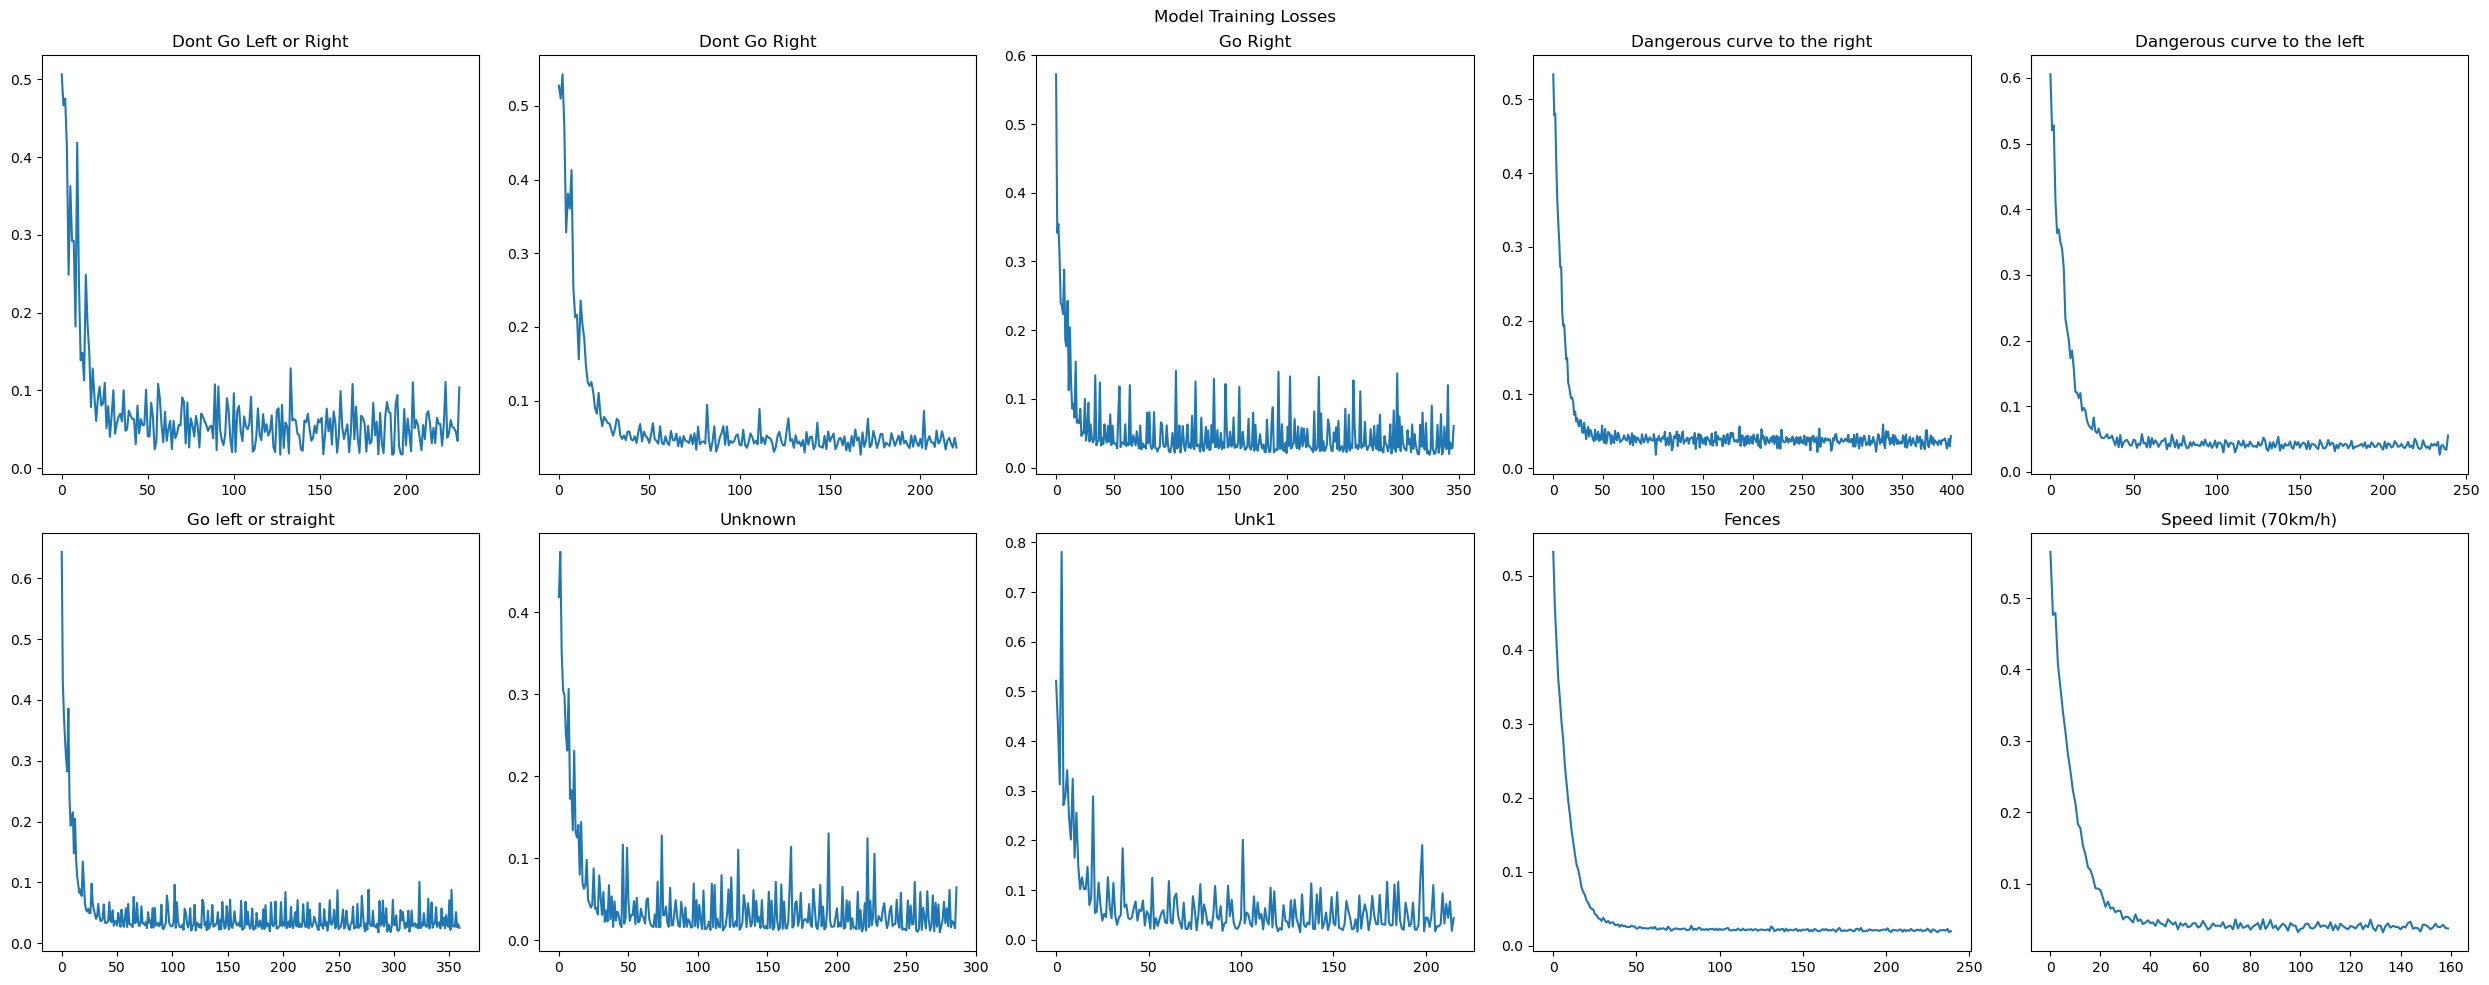

In [30]:
plot_losses(losses,1)

In [33]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [80]:
evaluate_models(diffusion_models[0], train_dataset_loader, device, type=2)

c:\Users\davic\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\davic\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Mean FID: 473.7032904707256, Mean SSIM: 0.39055911430494966, Mean IS: 1.0, STD IS: 1.2685487149610708e-07


In [32]:
dit_executionTime = 15 # In minutes

### **5. Generate images to be added to the dataset**

###### **Auxiliary Functions**

In [33]:
def generate_and_save_images(model, class_index, num_images, output_dir, latent_dim=0, device='cpu', type=1):
    os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it doesn't exist

    model.eval()  # Set the generator to evaluation mode

    with torch.no_grad():
        for img_num in range(num_images):
            if type==1: #cGAN
                noise = torch.randn(1, latent_dim, 1, 1, device=device)  # Generate random noise
                label = torch.tensor([class_index], dtype=torch.long, device=device)  # Class label

                # Generate the image
                generated_img = model(noise, label)
            else: #DiT  
                generated_img = model.sample(device)
            
            # Save the image 
            filename = os.path.join(output_dir, f'{class_index}\\class_{class_index}_img_{img_num}.png')
            vutils.save_image(generated_img, filename, normalize=True)
            
        print(f"Generated and saved {num_images} images for the {class_index} class.")

In [38]:
def augmented_data(train_dataset_loader, models, type, target_count, save_imgs=1):
    # Current training class distribution
    class_distribution = {0: 11, 1: 9, 2: 7, 3: 27, 4: 31, 5: 27, 6: 8, 7: 9, 8: 50, 9: 70}

    # Number of new images needed per class
    images_to_generate = {cls: target_count - count for cls, count in class_distribution.items()}

    if type==1: # cGAN
        if save_imgs==1:
            output_dir = 'generated_images\\cGAN'
            
            for class_index in range(N_CLASS):
                num_images = images_to_generate[class_index]
                generate_and_save_images(models[str(class_index)], class_index, num_images, output_dir, 128, device, 1)
            
        augmented_dataset_path = 'submission\\data\\cGAN' # path of the augmented data
        
    else: # DiT
        if save_imgs==1:
            output_dir = 'generated_images\\DiT'
            
            for class_index in range(N_CLASS):
                num_images = images_to_generate[class_index]
                generate_and_save_images(models[class_index], class_index, num_images, output_dir, device=device, type=2)
            
        augmented_dataset_path = 'submission\\data\\DiT' # path of the augmented data
        
    if save_imgs!=1:
        #Load dataset from path   
        transform = transforms.Compose([transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),transforms.ToTensor()])
        augmented_dataset = datasets.ImageFolder(root=augmented_dataset_path, transform=transform)
        augmented_dataset_loader = DataLoader(augmented_dataset, batch_size=64, shuffle=True)  
        
        # Combine original and generated datasets
        combined_dataset = ConcatDataset([train_dataset_loader.dataset, augmented_dataset_loader.dataset])

        # Create a new DataLoader with the combined dataset
        train_augmented_dataset_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True)
        
        return train_augmented_dataset_loader

###### **cGAN**

In [69]:
train_augmented_dataset_loader_100 = augmented_data(train_dataset_loader, models, type=1, target_count=100)

In [95]:
train_augmented_dataset_loader_100 = augmented_data(train_dataset_loader, models, type=1, target_count=200)

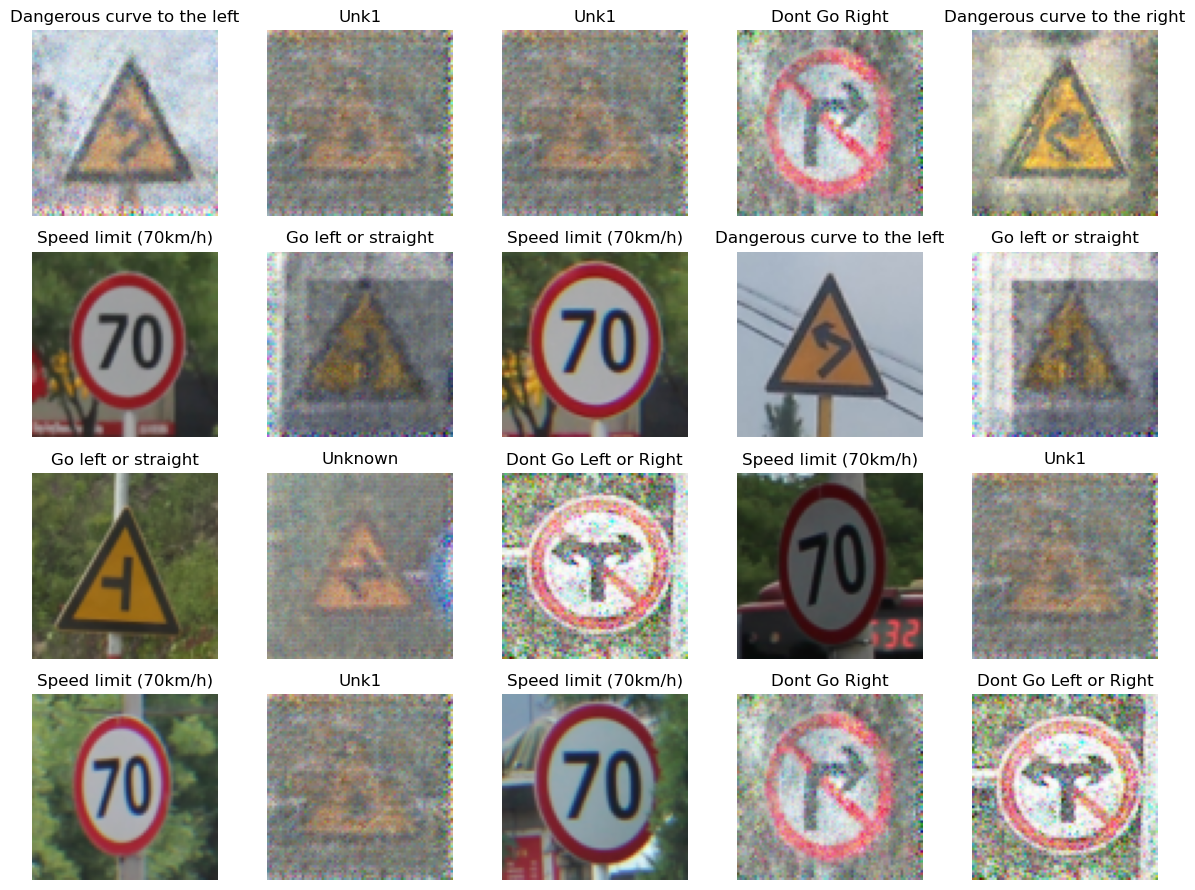

In [96]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(12, 9))
dataiter = iter(train_augmented_dataset_loader.dataset)
idx = 0

all_images_labels = list(train_augmented_dataset_loader.dataset)

for i in range(4):
    for j in range(5):
        img, l = random.choice(all_images_labels) # Randomly selecting an image and label
        label = the_real_labels[int(labels[l])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(img.permute(1,2,0))
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.show()

###### **DiT**

In [39]:
train_augmented_dataset_loader = augmented_data(train_dataset_loader,models=None, save_imgs=0,type=2, target_count=100)

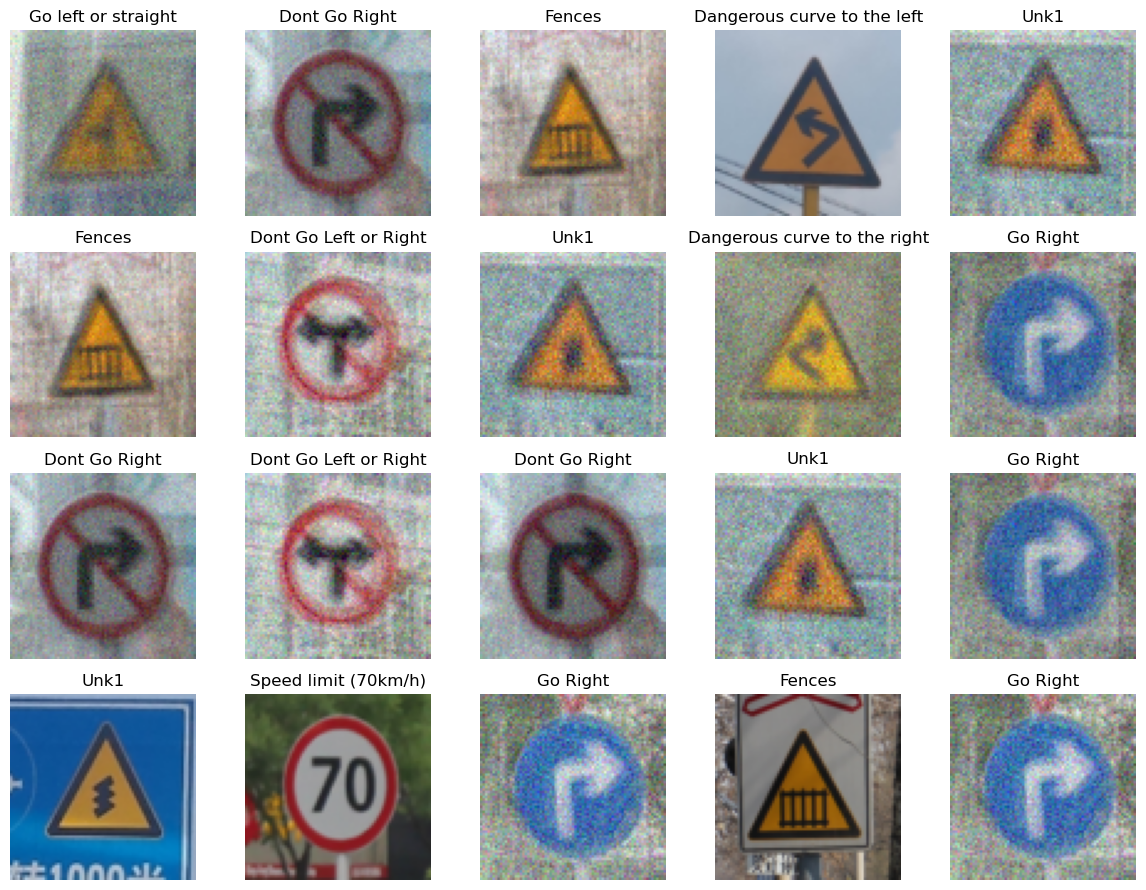

In [40]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(12, 9))
dataiter = iter(train_augmented_dataset_loader.dataset)
idx = 0

all_images_labels = list(train_augmented_dataset_loader.dataset)

for i in range(4):
    for j in range(5):
        img, l = random.choice(all_images_labels) # Randomly selecting an image and label
        label = the_real_labels[int(labels[l])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(img.permute(1,2,0))
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.show()

### **6. Model for Image Classification**

###### **Auxiliary function**

In [41]:
def save_file(model, dataloader, filename, device=device, to_device=True): # Predict Kaggle results
    # Set the model to evaluation mode
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() and to_device else "cpu")
    
    if to_device:
        model = model.to(device)
        
    pred_conv = []
    ids = []
    id = 0
    with torch.no_grad():
        for _, images in enumerate(dataloader):
            if to_device:
                images = images.to(device)
                
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) # gets the result with the highest probability
            
            # Convert tensors to numpy arrays
            if to_device:
                predicted = predicted.to("cpu")
            
            predicted = predicted.numpy()
            
            # Converts the predicted value to the correct label
            for i in range(len(predicted)):
                label = None
                if predicted[i] == 0:
                    label = 12
                elif predicted[i] == 1:
                    label = 13
                elif predicted[i] == 2:
                    label = 24
                elif predicted[i] == 3:
                    label = 38
                elif predicted[i] == 4:
                    label = 39
                elif predicted[i] == 5:
                    label = 44
                elif predicted[i] == 6:
                    label = 46
                elif predicted[i] == 7:
                    label = 49
                elif predicted[i] == 8:
                    label = 50
                elif predicted[i] == 9:
                    label = 6
                
                id+=1
                pred_conv.append(label)
                ids.append(id)
    
    # Save output
    df = pd.DataFrame({'ID': ids, 'TARGET': pred_conv})
    df.to_csv(filename, index=False)

###### **Architecture**

In [42]:
class CustomCNN(nn.Module):
    def __init__(self, img_width, img_height, num_classes):
        super(CustomCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=5, padding='valid')
        self.bn1 = nn.BatchNorm2d(num_features=128)
        
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding='valid', bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding='valid', bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        
        #self.fc1 = nn.Linear(32 * self._conv_output_shape(img_width, img_height), 256)  # Assuming square input for simplification
        self.fc1 = nn.Linear(1568,256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
        
        # L2 regularization is not directly included in layers in PyTorch, 
        # it's typically added to the optimizer during the training step.

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2)
        
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
    def _conv_output_shape(self, img_width, img_height, kernel_size=3, stride=1, padding=0, dilation=1):
        h = ((img_height + (2 * padding) - (dilation * (kernel_size - 1)) - 1) / stride) + 1
        w = ((img_width + (2 * padding) - (dilation * (kernel_size - 1)) - 1) / stride) + 1
        return int(h/8) * int(w/8)  # Considering three max pooling layers with kernel_size=2, stride=2

##### **Training**

In [43]:
def train_model(model, criterion, optimizer,train_dataset_loader, num_epochs=10, device='cpu'):
    model.to(device)
    for epoch in range(num_epochs):
        cumulative_loss = 0
        for batch_idx, (data, target) in enumerate(train_dataset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            #if (batch_idx + 1) % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Step {batch_idx+1}/{len(train_dataset_loader)}, Loss: {loss.item():.4f}')
            cumulative_loss += loss.item()
        print(f"Epoch {epoch+1} average loss: {cumulative_loss/len(train_dataset_loader)}")
    return model.to("cpu")

In [44]:
device = torch.device("cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():    
    device = torch.device("cuda")

num_classes = len(labels)
print(num_classes)
print(device)
num_epochs = 15
model = CustomCNN(IMG_WIDTH, IMG_HEIGHT, num_classes)
criterion = nn.CrossEntropyLoss()  
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

10
cuda


In [45]:
TRAIN_MODEL = True
if TRAIN_MODEL:
    ccnn = train_model(model, criterion, optimizer, train_augmented_dataset_loader, num_epochs, device)
    
else:
    ccnn = torch.load('baseline_model.pth')

Epoch 1/15, Step 1/55, Loss: 2.2940
Epoch 1/15, Step 2/55, Loss: 2.2844
Epoch 1/15, Step 3/55, Loss: 2.2000
Epoch 1/15, Step 4/55, Loss: 2.1546
Epoch 1/15, Step 5/55, Loss: 2.1492
Epoch 1/15, Step 6/55, Loss: 1.9000
Epoch 1/15, Step 7/55, Loss: 1.8116
Epoch 1/15, Step 8/55, Loss: 1.8057
Epoch 1/15, Step 9/55, Loss: 1.8176
Epoch 1/15, Step 10/55, Loss: 1.6344
Epoch 1/15, Step 11/55, Loss: 1.5848
Epoch 1/15, Step 12/55, Loss: 1.6140
Epoch 1/15, Step 13/55, Loss: 1.4562
Epoch 1/15, Step 14/55, Loss: 1.3297
Epoch 1/15, Step 15/55, Loss: 1.4355
Epoch 1/15, Step 16/55, Loss: 1.3752
Epoch 1/15, Step 17/55, Loss: 1.2077
Epoch 1/15, Step 18/55, Loss: 1.0475
Epoch 1/15, Step 19/55, Loss: 1.0130
Epoch 1/15, Step 20/55, Loss: 1.0496
Epoch 1/15, Step 21/55, Loss: 1.0411
Epoch 1/15, Step 22/55, Loss: 1.0878
Epoch 1/15, Step 23/55, Loss: 0.8440
Epoch 1/15, Step 24/55, Loss: 0.9451
Epoch 1/15, Step 25/55, Loss: 0.7837
Epoch 1/15, Step 26/55, Loss: 0.6482
Epoch 1/15, Step 27/55, Loss: 0.7633
Epoch 1/15

##### **Evaluation**

In [46]:
def test_model(model, dataset_loader):
    y_real = []
    y_pred = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in dataset_loader:
            y_real.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the {} test images: {} %'.format(total,100 * correct / total))
    # Generate the confusion matrix
    cm = confusion_matrix(y_real, y_pred)
    f1 = f1_score(y_real, y_pred, average='weighted')
    accuracy = accuracy_score(y_real, y_pred)
    precision = precision_score(y_real, y_pred, average='weighted')

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    
    print('F1_Score:', f1)
    print('Accuracy Score:', accuracy)
    print('Precision Score:', precision)

###### **Baseline Model**

Accuracy of the model on the 28 test images: 75.0 %


c:\Users\davic\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


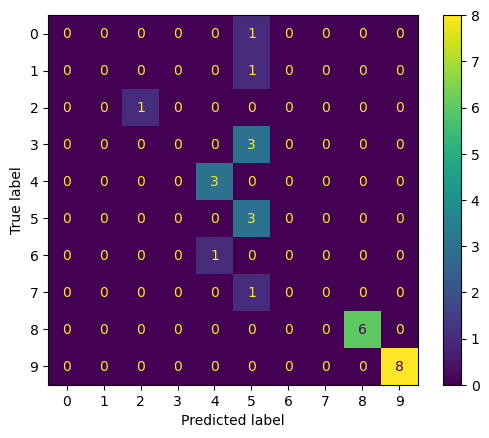

F1_Score: 0.6811224489795917
Accuracy Score: 0.75
Precision Score: 0.6517857142857143
None


In [28]:
print(test_model(ccnn, validation_dataset_loader))

In [59]:
save_file(ccnn, test_dataset_loader, 'baseline_model.csv', device)

###### **cGAN**

Accuracy of the model on the 28 test images: 92.85714285714286 %


c:\Users\davic\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


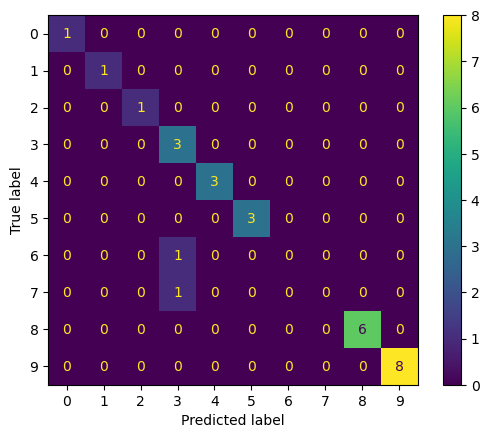

F1_Score: 0.9017857142857143
Accuracy Score: 0.9285714285714286
Precision Score: 0.8857142857142858
None


In [98]:
print(test_model(ccnn, validation_dataset_loader))

In [100]:
save_file(ccnn, test_dataset_loader, 'cGAN_model.csv', device)

###### **DiT**

Accuracy of the model on the 28 test images: 92.85714285714286 %


c:\Users\davic\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


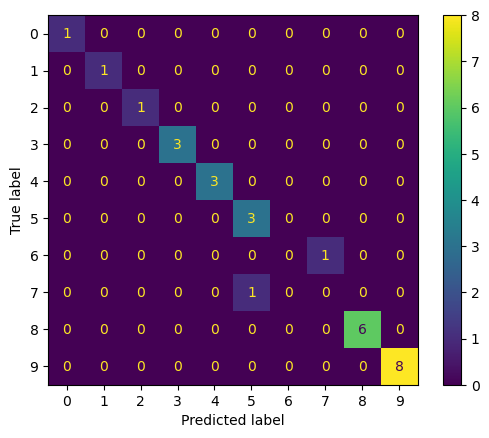

F1_Score: 0.9132653061224489
Accuracy Score: 0.9285714285714286
Precision Score: 0.9017857142857143
None


In [47]:
print(test_model(ccnn, validation_dataset_loader))

In [48]:
save_file(ccnn, test_dataset_loader, 'ViT_model.csv', device)

### **7. Plots**

##### **Auxiliary Function**

In [64]:
def plot_results(labels,train,validation=None,test=None,title=None, n_values=3, text=''): 
    colors = {'Train': 'lightblue', 'Validation': 'orange', 'Test': 'yellow'}

    if n_values == 3:
        data = pd.DataFrame({
            'Model': labels * 3,
            'Score': train + validation + test,
            'Set': ['Train'] * len(labels) + ['Validation'] * len(labels) + ['Test'] * len(labels)
        })
    elif n_values == 2:
        data = pd.DataFrame({
            'Model': labels * 2,
            f'{text}': train + validation,
            'Set': ['Train'] * len(labels) + ['Validation'] * len(labels)
        })
    else:
        data = pd.DataFrame({
            'Model': labels,
            f'{text}': train,
            'Set': ['Train'] * len(labels)
        })

    plt.figure(figsize=(12, 8))
    if n_values==3:
        sns.barplot(data=data, x='Model', y='Score', hue='Set', palette=colors)
        plt.axhline(y=1, color='red', linestyle='--', label='Threshold')  # Plot a red line at y=1
    elif n_values== 2:
        sns.barplot(data=data, x='Model', y=f'{text}', hue='Set', palette=colors)
    else:
        sns.barplot(data=data, x='Model', y=f'{text}', hue='Set', palette=colors)
    
    for p in plt.gca().patches:
        plt.gca().annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                        textcoords='offset points')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

##### **Data Generation Part**

###### **Execution Time**

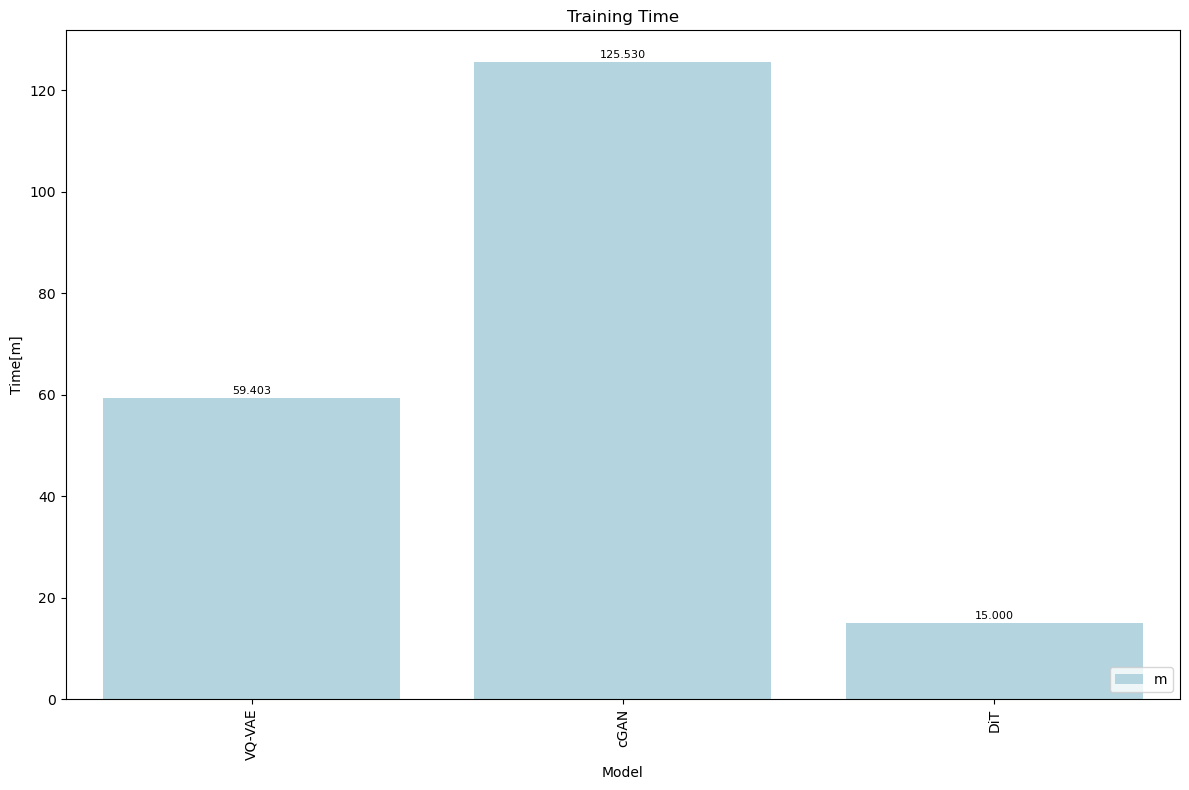

In [106]:
vq_vae_executionTime = 59.403 
conditional_gan_executionTime = 125.53
dit_executionTime = 15
labels = ['VQ-VAE', 'cGAN', 'DiT']
train = [vq_vae_executionTime, conditional_gan_executionTime, dit_executionTime]
plot_results(labels, train, n_values=1, title='Training Time', text='Time[m]')

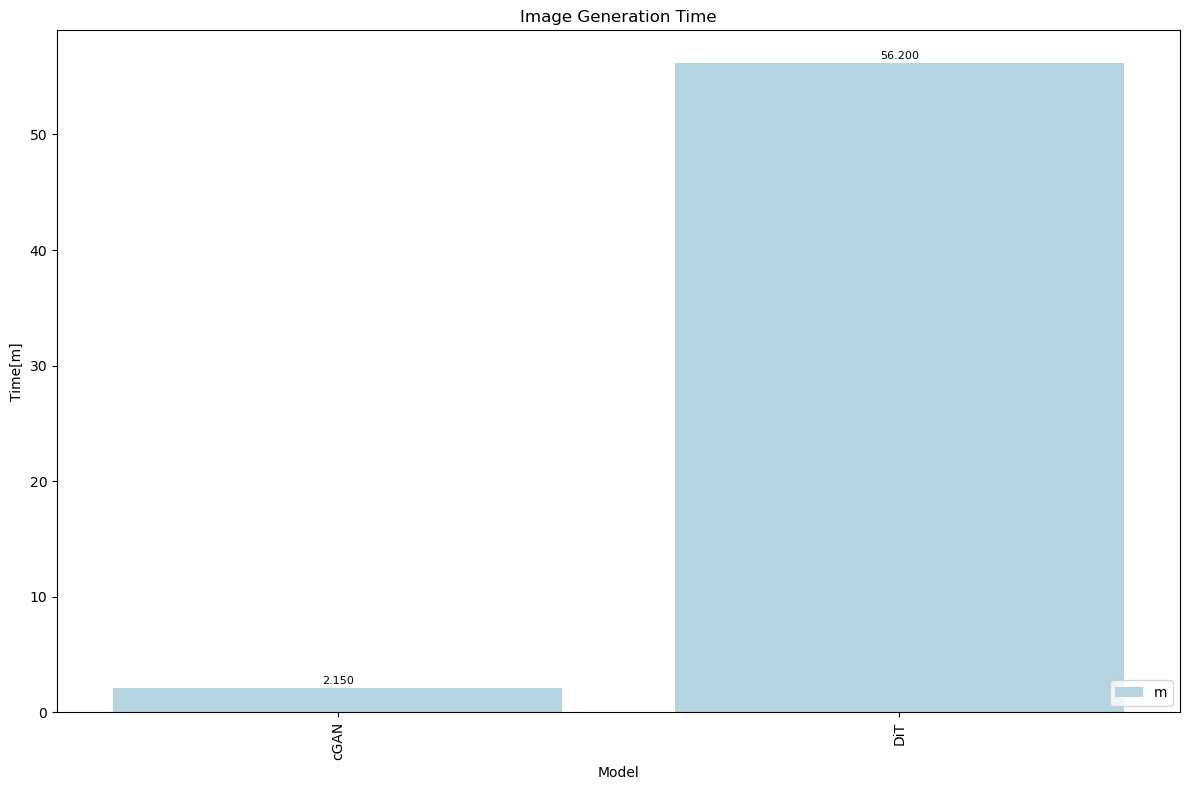

In [107]:
labels = ['cGAN', 'DiT']
train = [2.15, 56.2]
plot_results(labels, train, n_values=1, title='Image Generation Time', text='Time[m]')

###### **Inception Score**

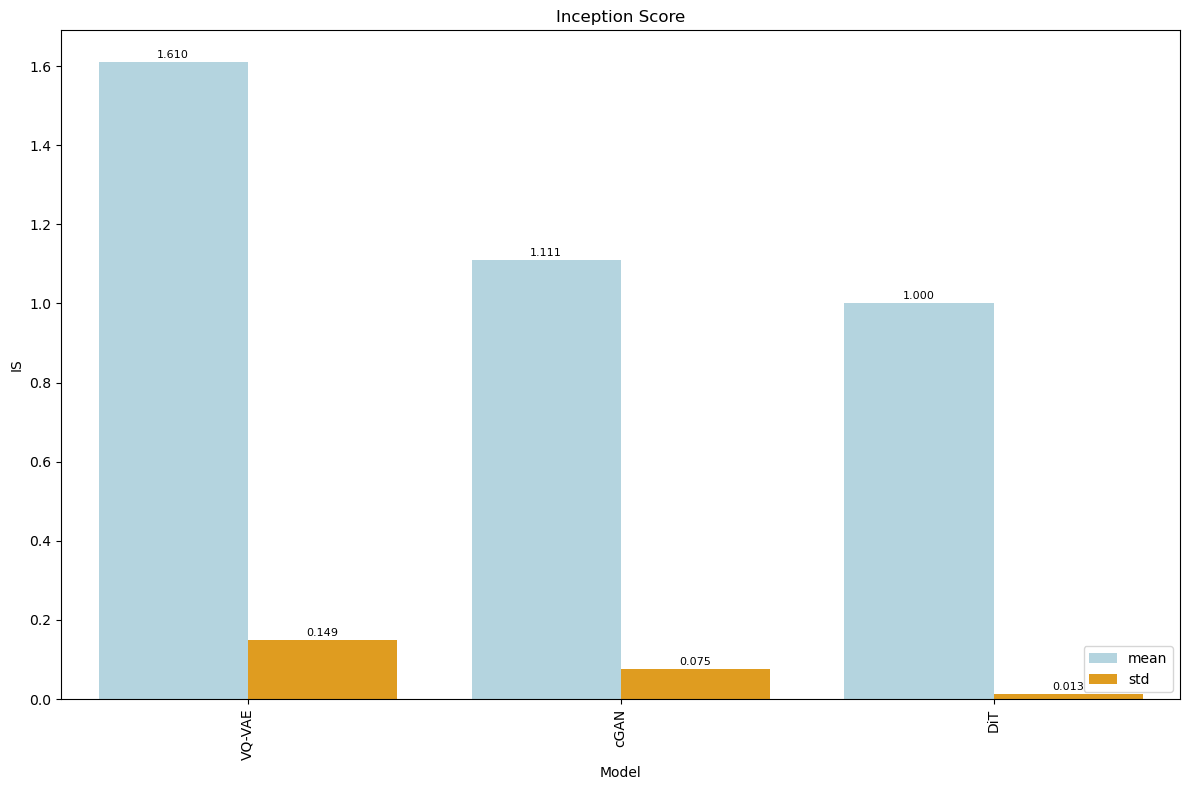

In [99]:
mean_is_vq_vae = 1.6097080707550049
std_is_vq_vae = 0.1488834172487259

mean_is_cGAN = 1.110503911972046
std_is_cGAN = 0.07512623071670532

mean_is_DiT = 1.0
std_is_DiT = 1.2685487149610708e-02

labels = ['VQ-VAE', 'cGAN', 'DiT']

plot_results(labels, [mean_is_vq_vae, mean_is_cGAN, mean_is_DiT], [std_is_vq_vae, std_is_cGAN, std_is_DiT], n_values=2, text='IS', title='Inception Score')

###### **Fréchet inception distance**

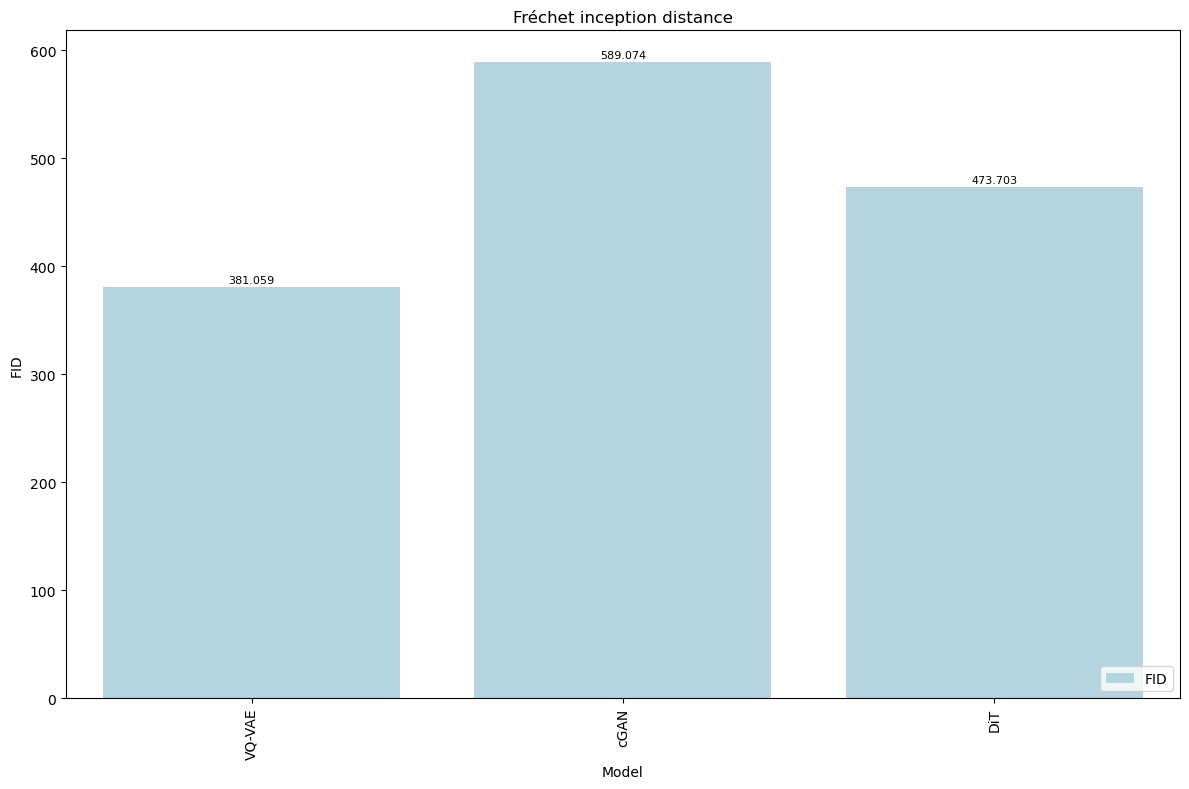

In [101]:
fid_vq_vae = 381.0594118360659
fid_cGAN = 589.074112086958
fid_DiT = 473.7032904707256

labels = ['VQ-VAE', 'cGAN', 'DiT']
train = [fid_vq_vae, fid_cGAN, fid_DiT]
plot_results(labels, train, n_values=1, title='Fréchet inception distance', text='FID')

###### **Structural Similarity Index**

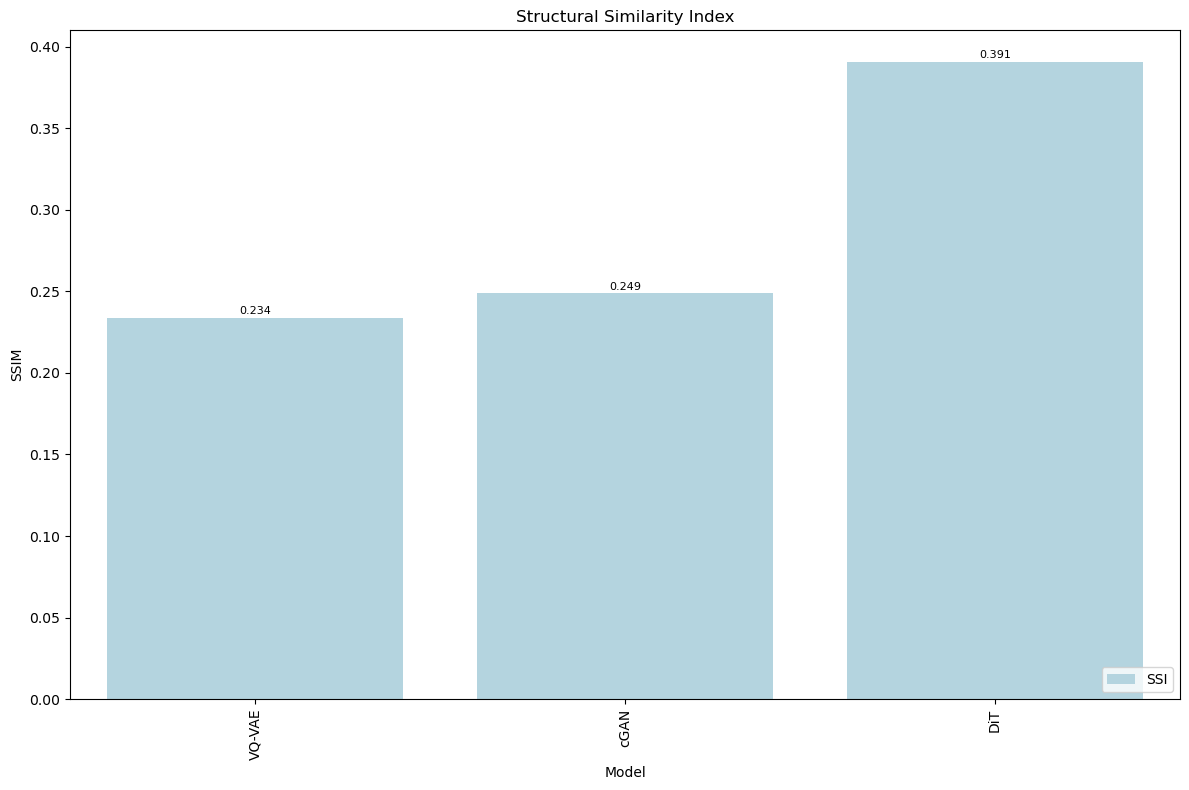

In [103]:
ssim_vq_vae = 0.23350442873429386
ssim_cGAN = 0.2487293165773094
ssim_DiT = 0.39055911430494966

labels = ['VQ-VAE', 'cGAN', 'DiT']
train = [ssim_vq_vae, ssim_cGAN, ssim_DiT]
plot_results(labels, train, n_values=1, title='Structural Similarity Index', text='SSIM')

##### **Labels Classification Part**

###### **F1 scores**

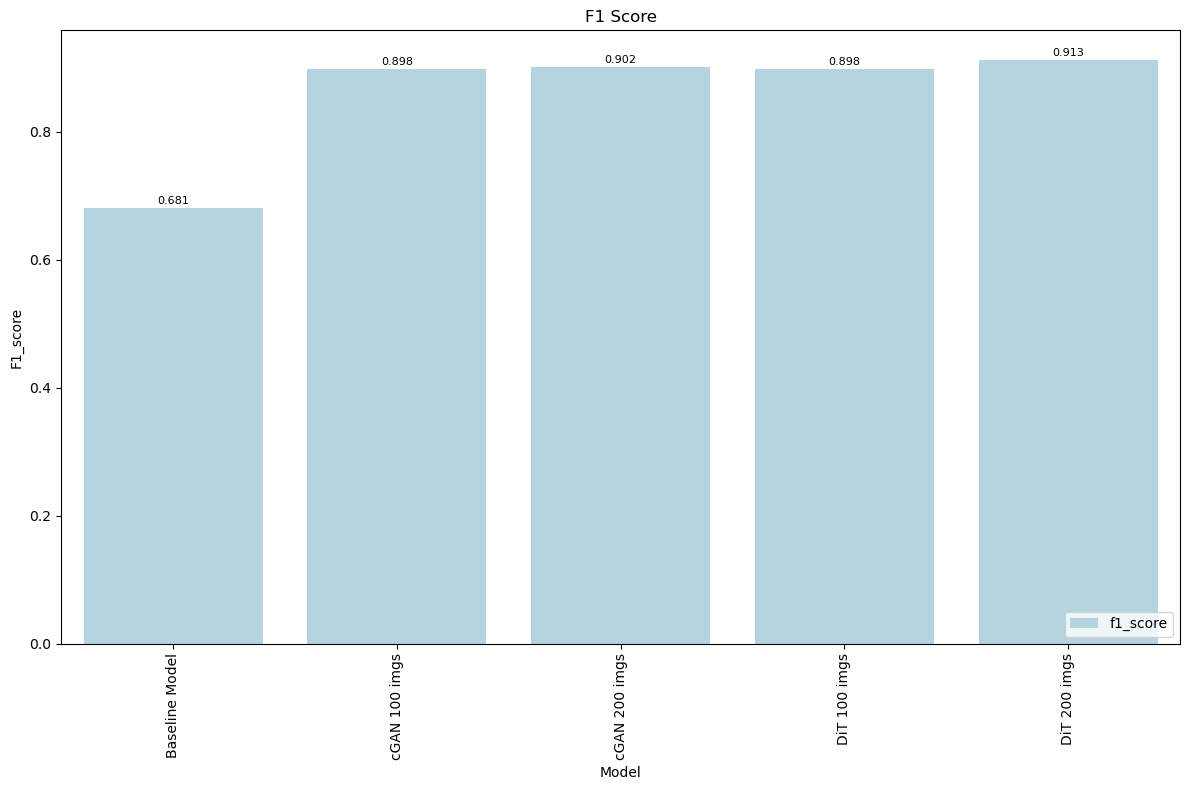

In [52]:
f1_Score_baseline_model = 0.6811224489795917
f1_Score_cGAN_100 = 0.8979591836734694
f1_Score_cGAN_200 = 0.9017857142857143
f1_Score_ViT_100 = 0.8979591836734694
f1_Score_ViT_200 = 0.9132653061224489

labels = ['Baseline Model', 'cGAN 100 imgs', 'cGAN 200 imgs','DiT 100 imgs', 'DiT 200 imgs']
train = [f1_Score_baseline_model, f1_Score_cGAN_100, f1_Score_cGAN_200, f1_Score_ViT_100, f1_Score_ViT_200]
plot_results(labels, train, n_values=1, title='F1 Score', text='F1_score')

###### **Accuracies**

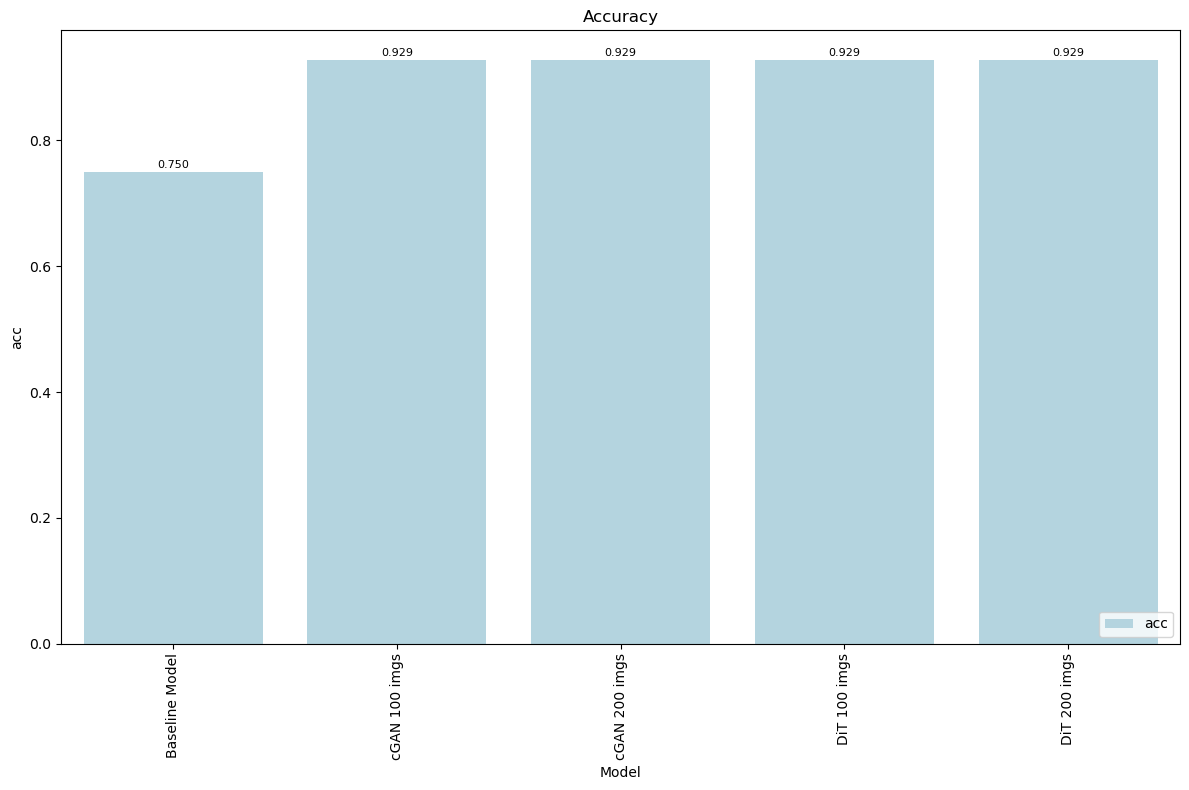

In [56]:
accuracy_baseline_model = 0.75
accuracy_cGAN_100 = 0.9285714285714286
accuracy_cGAN_200 = 0.9285714285714286
accuracy_ViT_100 = 0.9285714285714286
accuracy_ViT_200 = 0.9285714285714286

labels = ['Baseline Model', 'cGAN 100 imgs', 'cGAN 200 imgs','DiT 100 imgs', 'DiT 200 imgs']
train = [accuracy_baseline_model, accuracy_cGAN_100, accuracy_cGAN_200, accuracy_ViT_100, accuracy_ViT_200]
plot_results(labels, train, n_values=1, title='Accuracy', text='acc')

###### **Precisions**

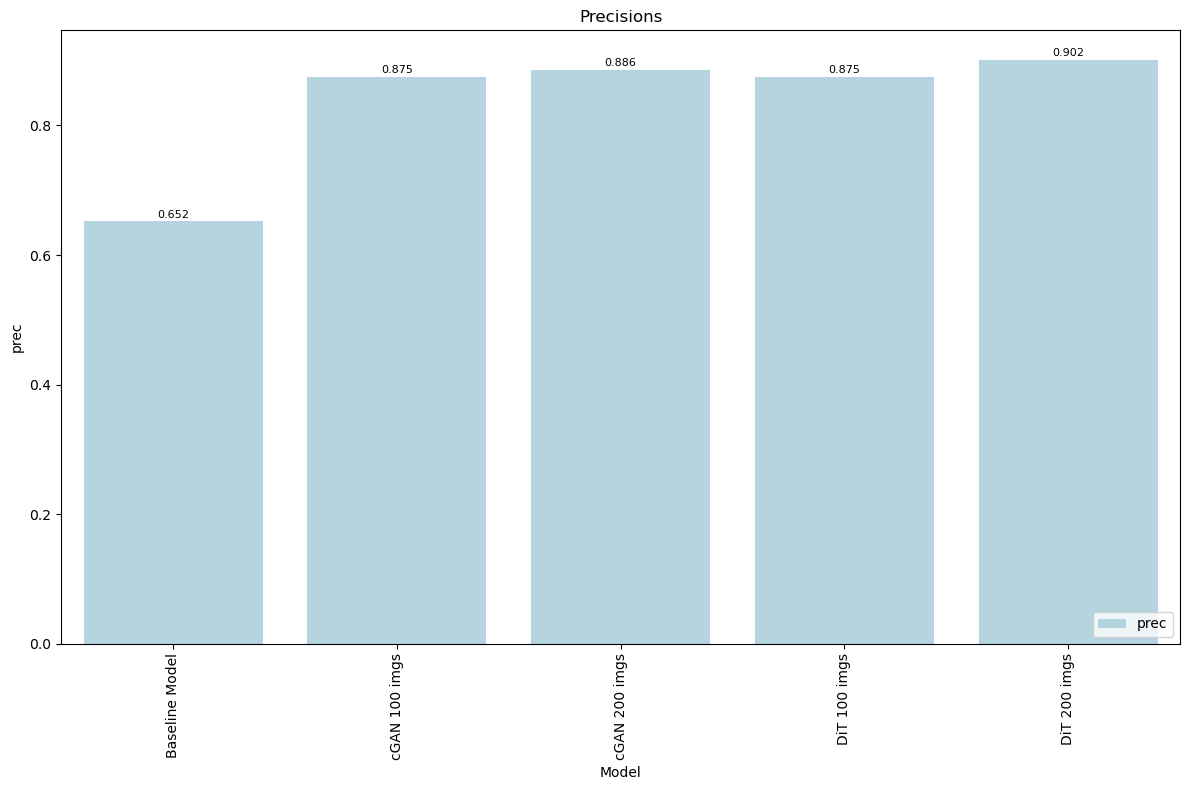

In [63]:
precision_baseline_model = 0.6517857142857143
precision_cGAN_100 = 0.875
precision_cGAN_200 = 0.8857142857142858
precision_ViT_100 = 0.875
precision_ViT_200 = 0.9017857142857143

labels = ['Baseline Model', 'cGAN 100 imgs', 'cGAN 200 imgs','DiT 100 imgs', 'DiT 200 imgs']
train = [precision_baseline_model, precision_cGAN_100, precision_cGAN_200, precision_ViT_100, precision_ViT_200]
plot_results(labels, train, n_values=1, title='Precisions', text='prec')

###### **Kaggle Results**

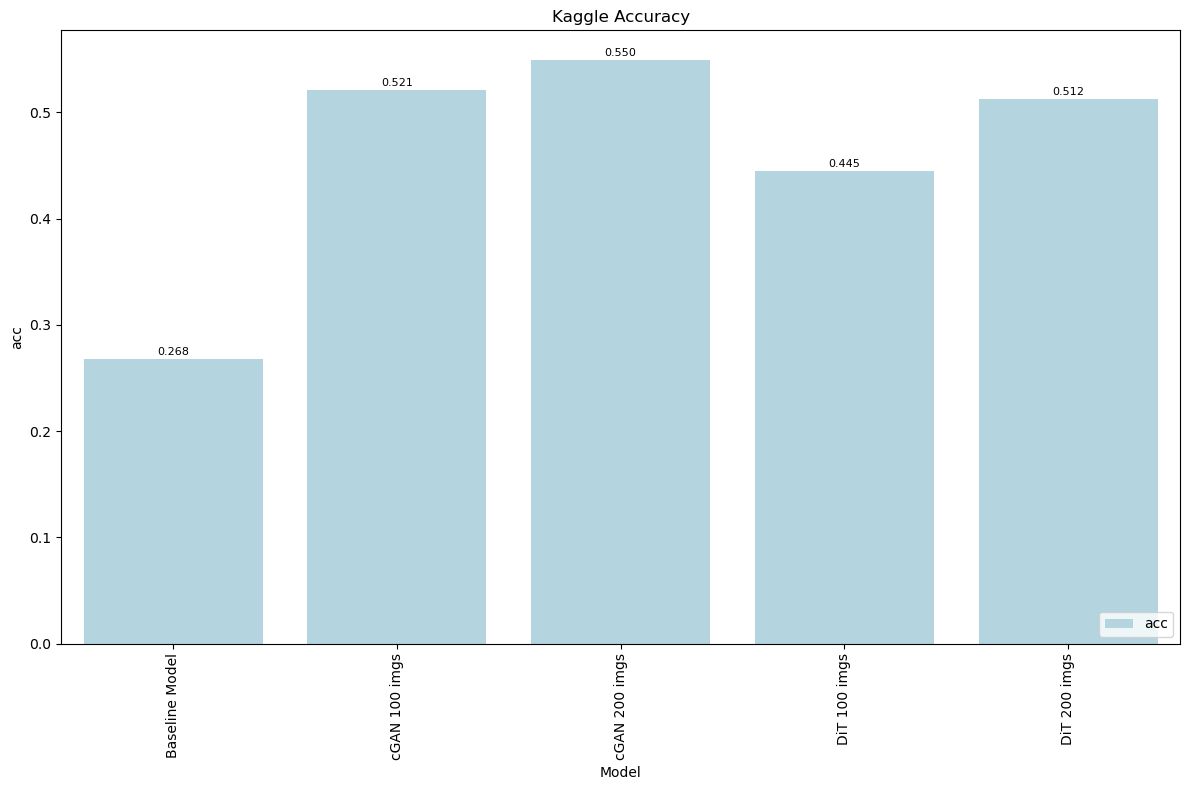

In [65]:
kaggle_baseline_model = 0.26767
kaggle_cGAN_100 = 0.52099
kaggle_cGAN_200 = 0.54979
kaggle_ViT_100 = 0.44504
kaggle_ViT_200 = 0.51245

labels = ['Baseline Model', 'cGAN 100 imgs', 'cGAN 200 imgs','DiT 100 imgs', 'DiT 200 imgs']
train = [kaggle_baseline_model, kaggle_cGAN_100, kaggle_cGAN_200, kaggle_ViT_100, kaggle_ViT_200]
plot_results(labels, train, n_values=1, title='Kaggle Accuracy', text='acc')